# Análisis de discrimante lineal


En 1936, Fisher formuló su teoría para el discriminate lineal (Lineal discriminant) el cual tiene muchas utilidades como clasificador.

Su concepto es similar al del PCA en el cual trata de realizar una reducción de similaridad, pero mientras el PCA es un aprendizaje **no supervisado** el LDA es **supervisado**. Utilizando esta información buscaremos la proyección que mejor nos permita separar las dos clases de interés.

![](img/proyeccion.png)

Consideremos que tenemos dos clases y un vector sobre el que proyectaremos las dos clases, de tal forma que podamos resumir el valor de cada muestra en una sola dimensión. 
\\[
\vec y = X · \vec{w}
\\]
Donde
* X son los datos que queremos clasificar $X \in \mathbb{R}^{N\times p}$
* w es el vector de proyección, $w \in \mathbb{R}^{p\times1}$
* y son los datos proyectados, $y \in \mathbb{R}^{N\times1}$

Si, sobre el valor de $y$ definimos un umbral $th_0$ tal que si $y \geq th_0$ pertenece a una clase y si no a la otra. La elección del umbral y del vector $\vec w$ determinarán la calidad del decisor.

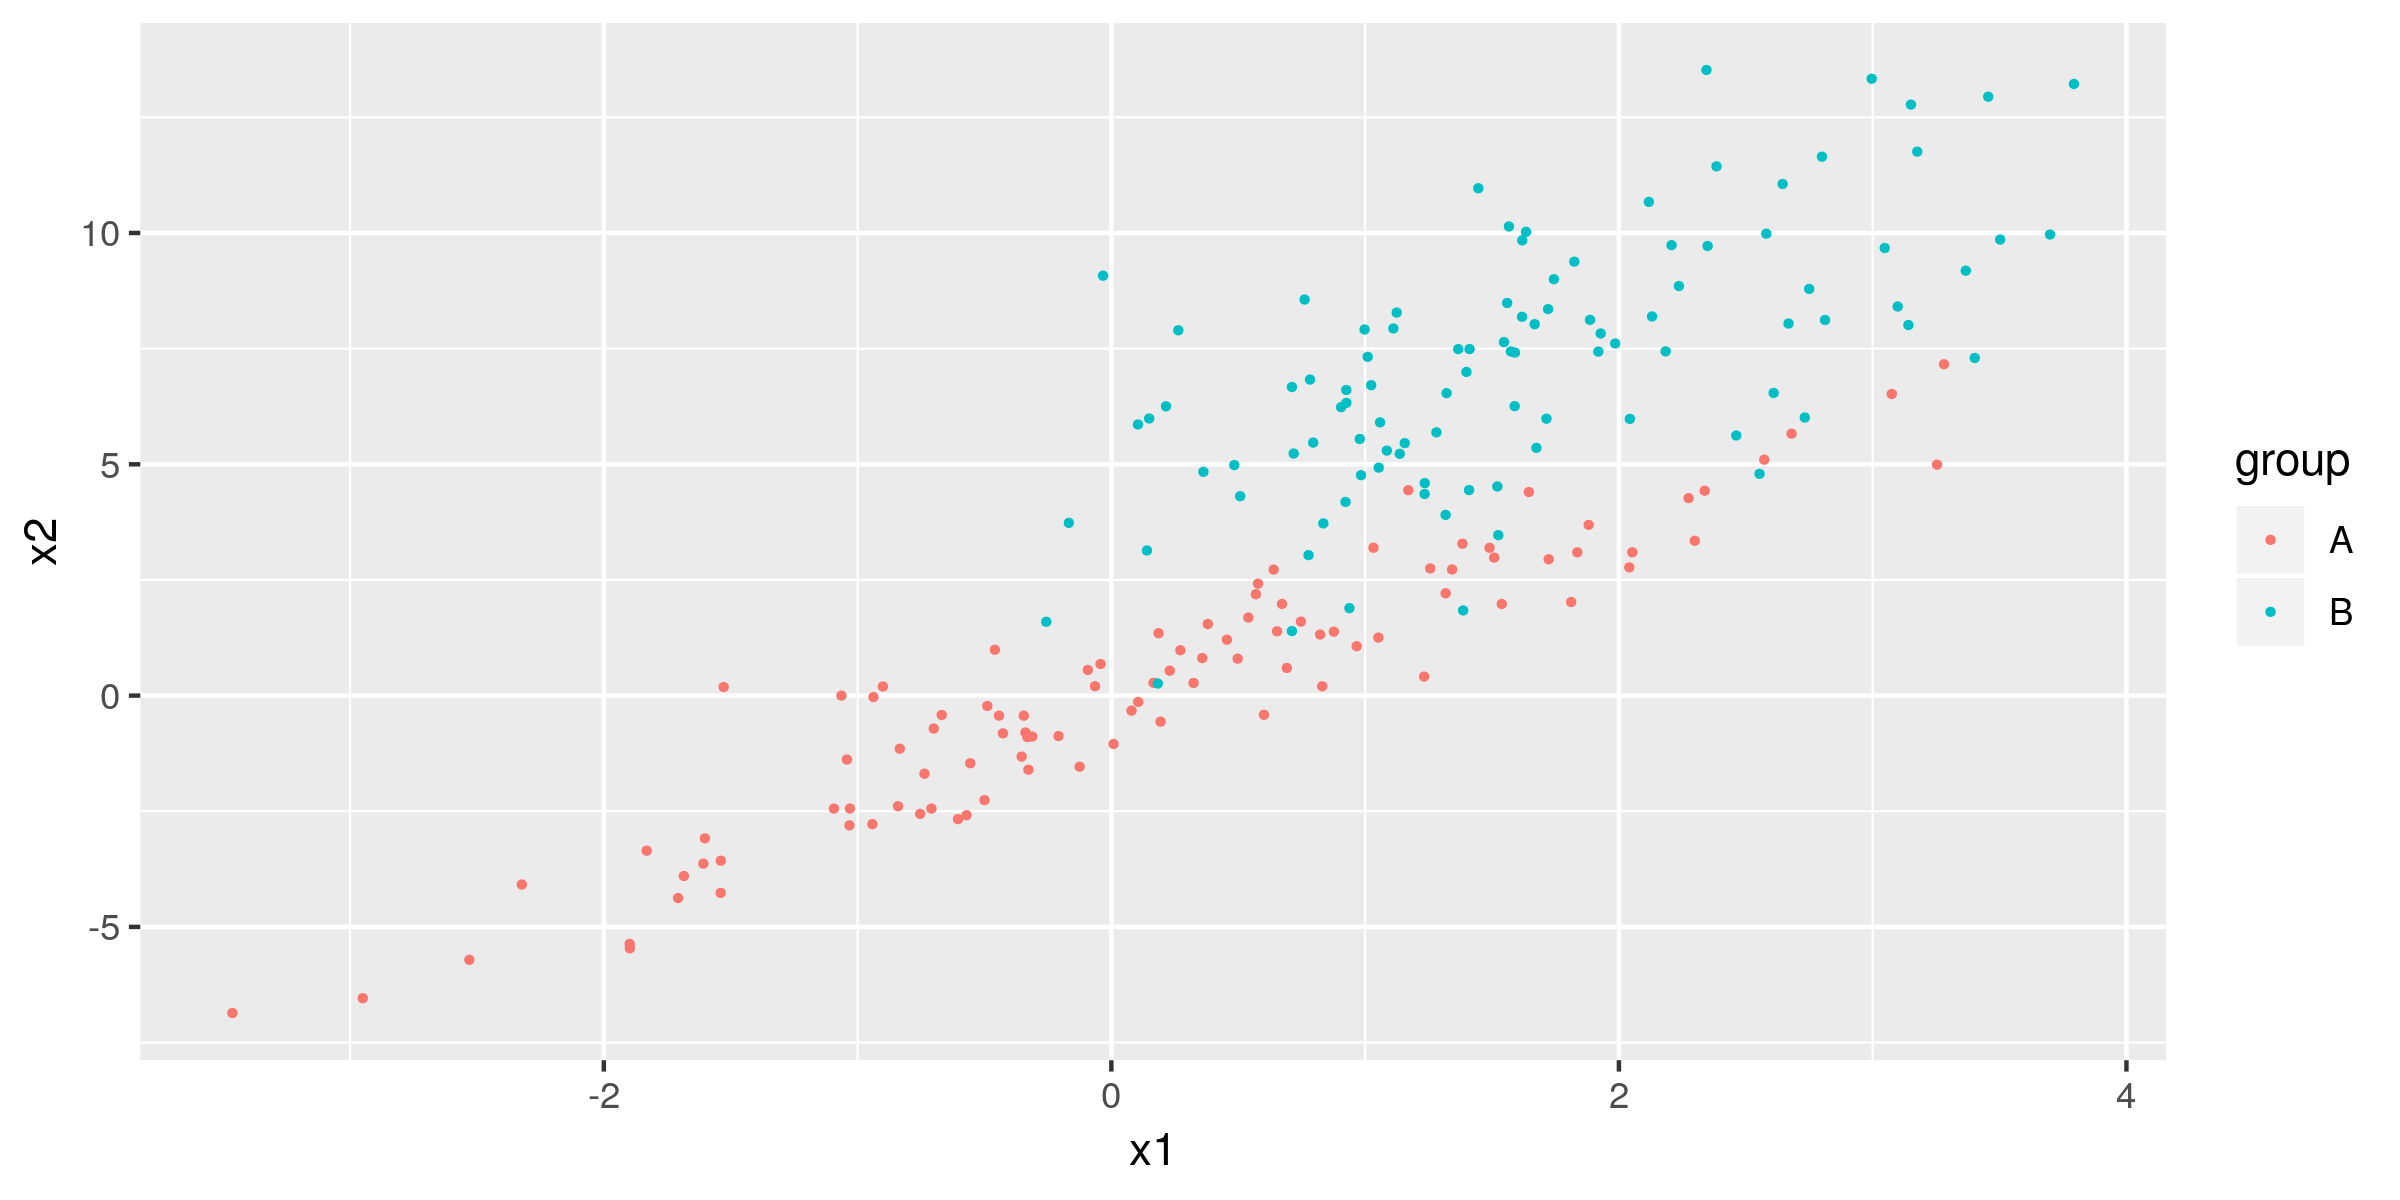

In [3]:
set.seed(123)
options(repr.plot.height=6,repr.plot.width=6,repr.plot.res = 300)

N<-100
x1<-rnorm(N,mean=0,sd=1.5)
x2<-x1*2+rnorm(N,mean=0,sd=1)
dfa<-data.frame(group="A",x1=x1,x2=x2)

x1<-rnorm(N,mean=1.5,sd=1)
x2<-x1*2+rnorm(N,mean=4,sd=2)
dfb<-data.frame(group="B",x1=x1,x2=x2)

df<-data.frame(rbind(dfa,dfb))
options(repr.plot.height=4,repr.plot.width=8)
library(ggplot2)
ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.5)

[1] "The AUC is 0.9265"

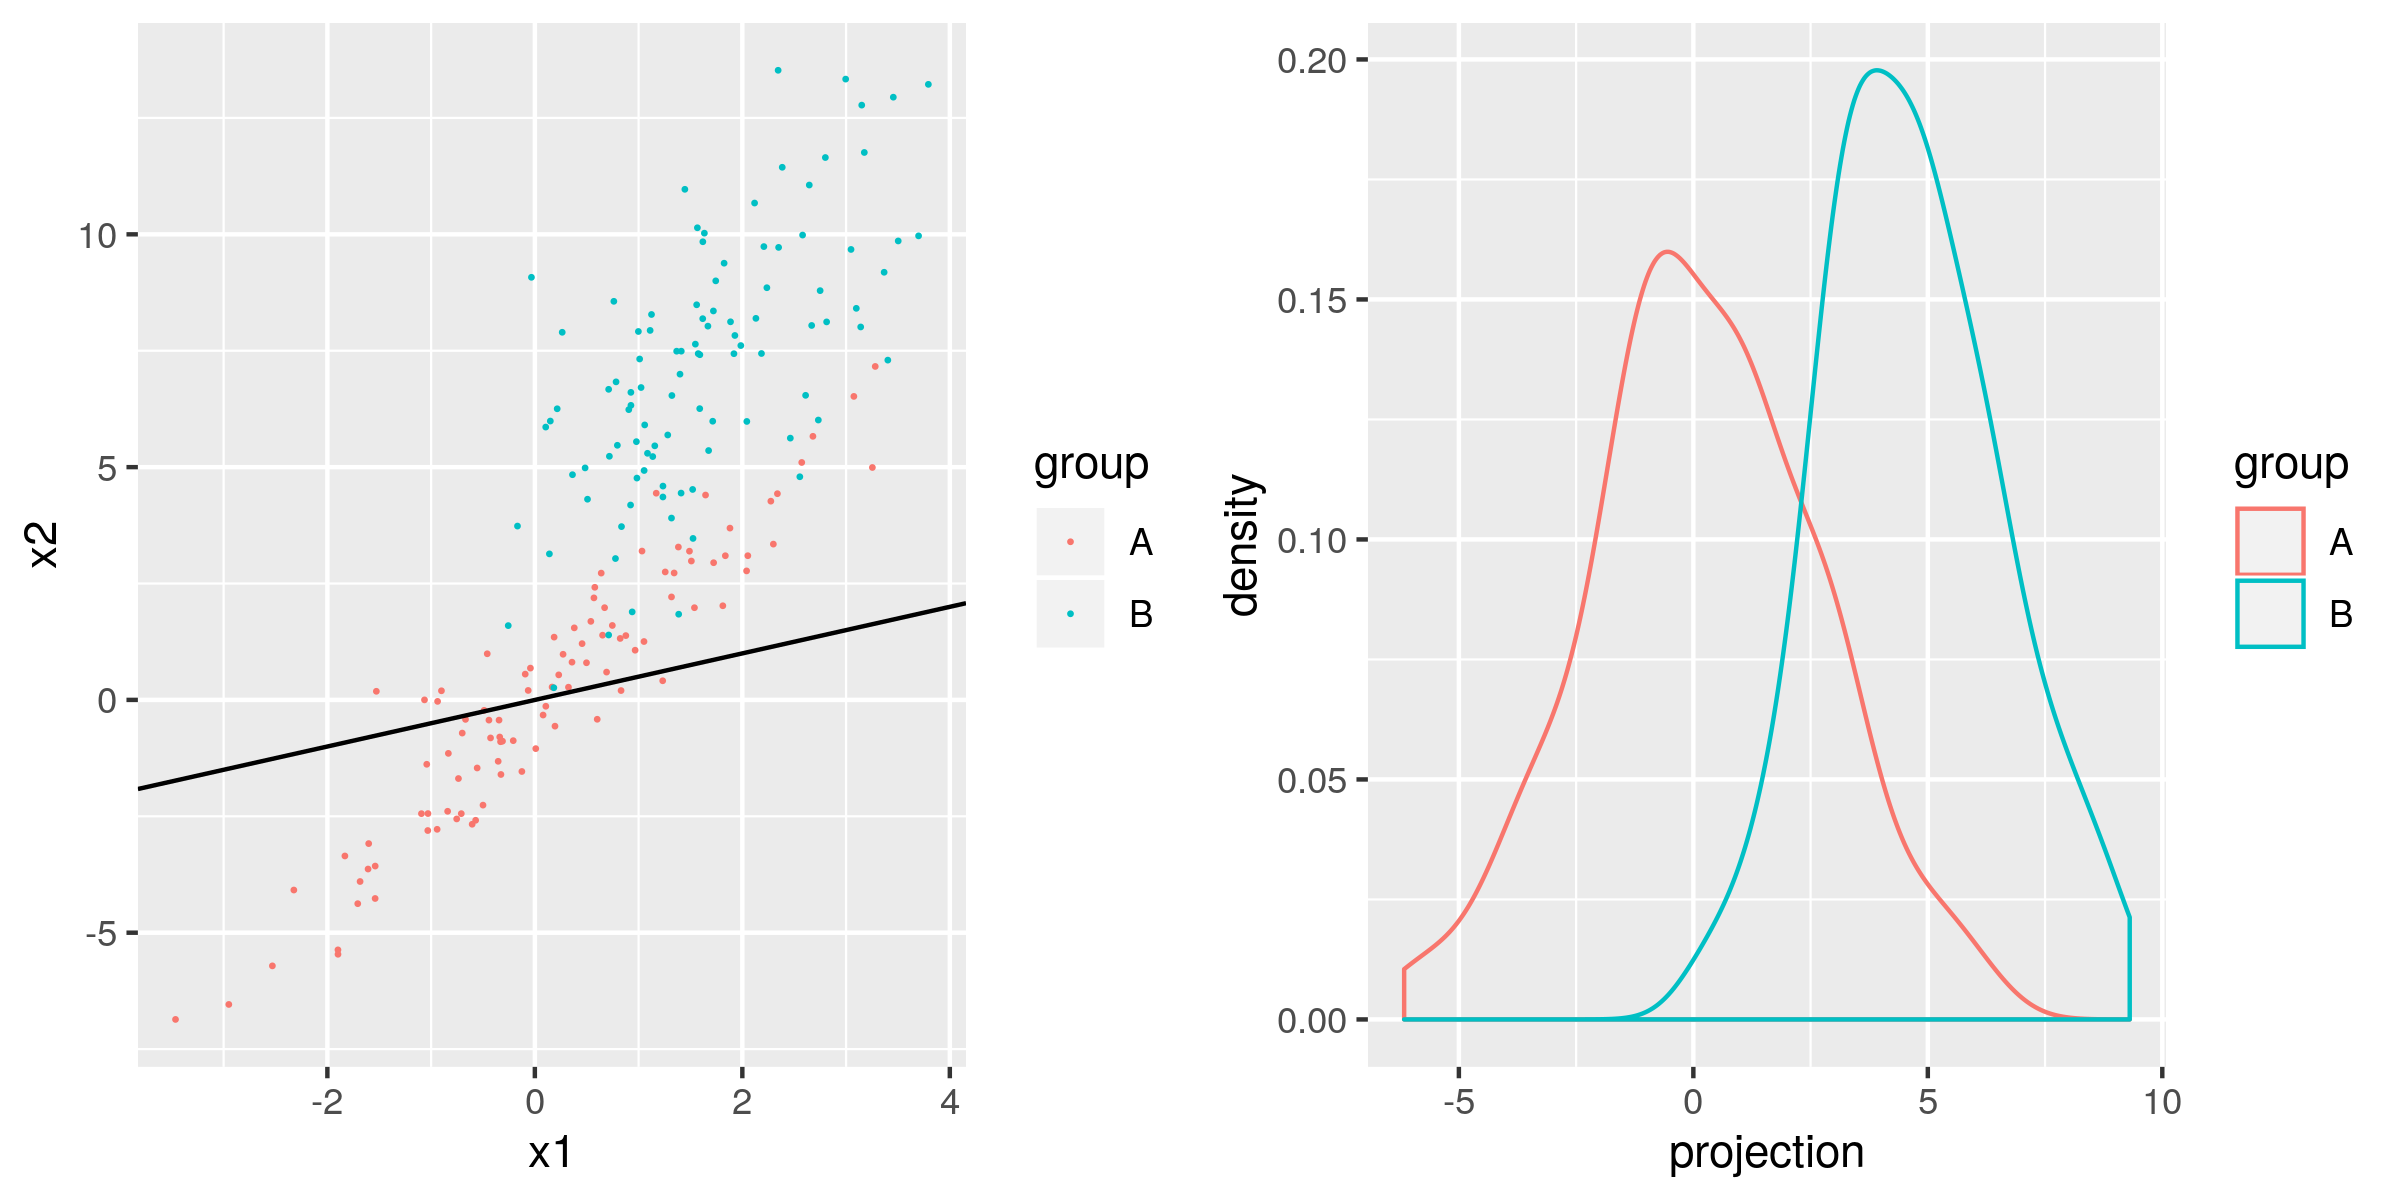

In [7]:
w<-matrix(c(1,0.5),nrow = 2)
w<-w/sqrt(sum(w^2))

g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])
df$projection<-as.matrix(df[,2:3]) %*% w
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()

library(ggpubr)
ggarrange(g1,g2,ncol = 2)
library(ROCR)

pr <- prediction(df$projection, df$group)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

Una posible idea sería seleccionar un vector $w$ tal que:
\\[    
\vec w \propto (\vec m_B- \vec m_A) 
\\]
Donde:
\\[
\vec m_n=\frac{1}{N_n}\sum_{n \in C_n}{\vec{x_n}}
\\]

In [8]:
mA<-as.matrix(colMeans(subset(df,group=="A")[,c("x1","x2")]))
mB<-as.matrix(colMeans(subset(df,group=="B")[,c("x1","x2")]))
w <- mB-mA
w <- w/sum(w^2)
w

x1,0.02896025
x2,0.13662008


[1] "The AUC is 0.9602"

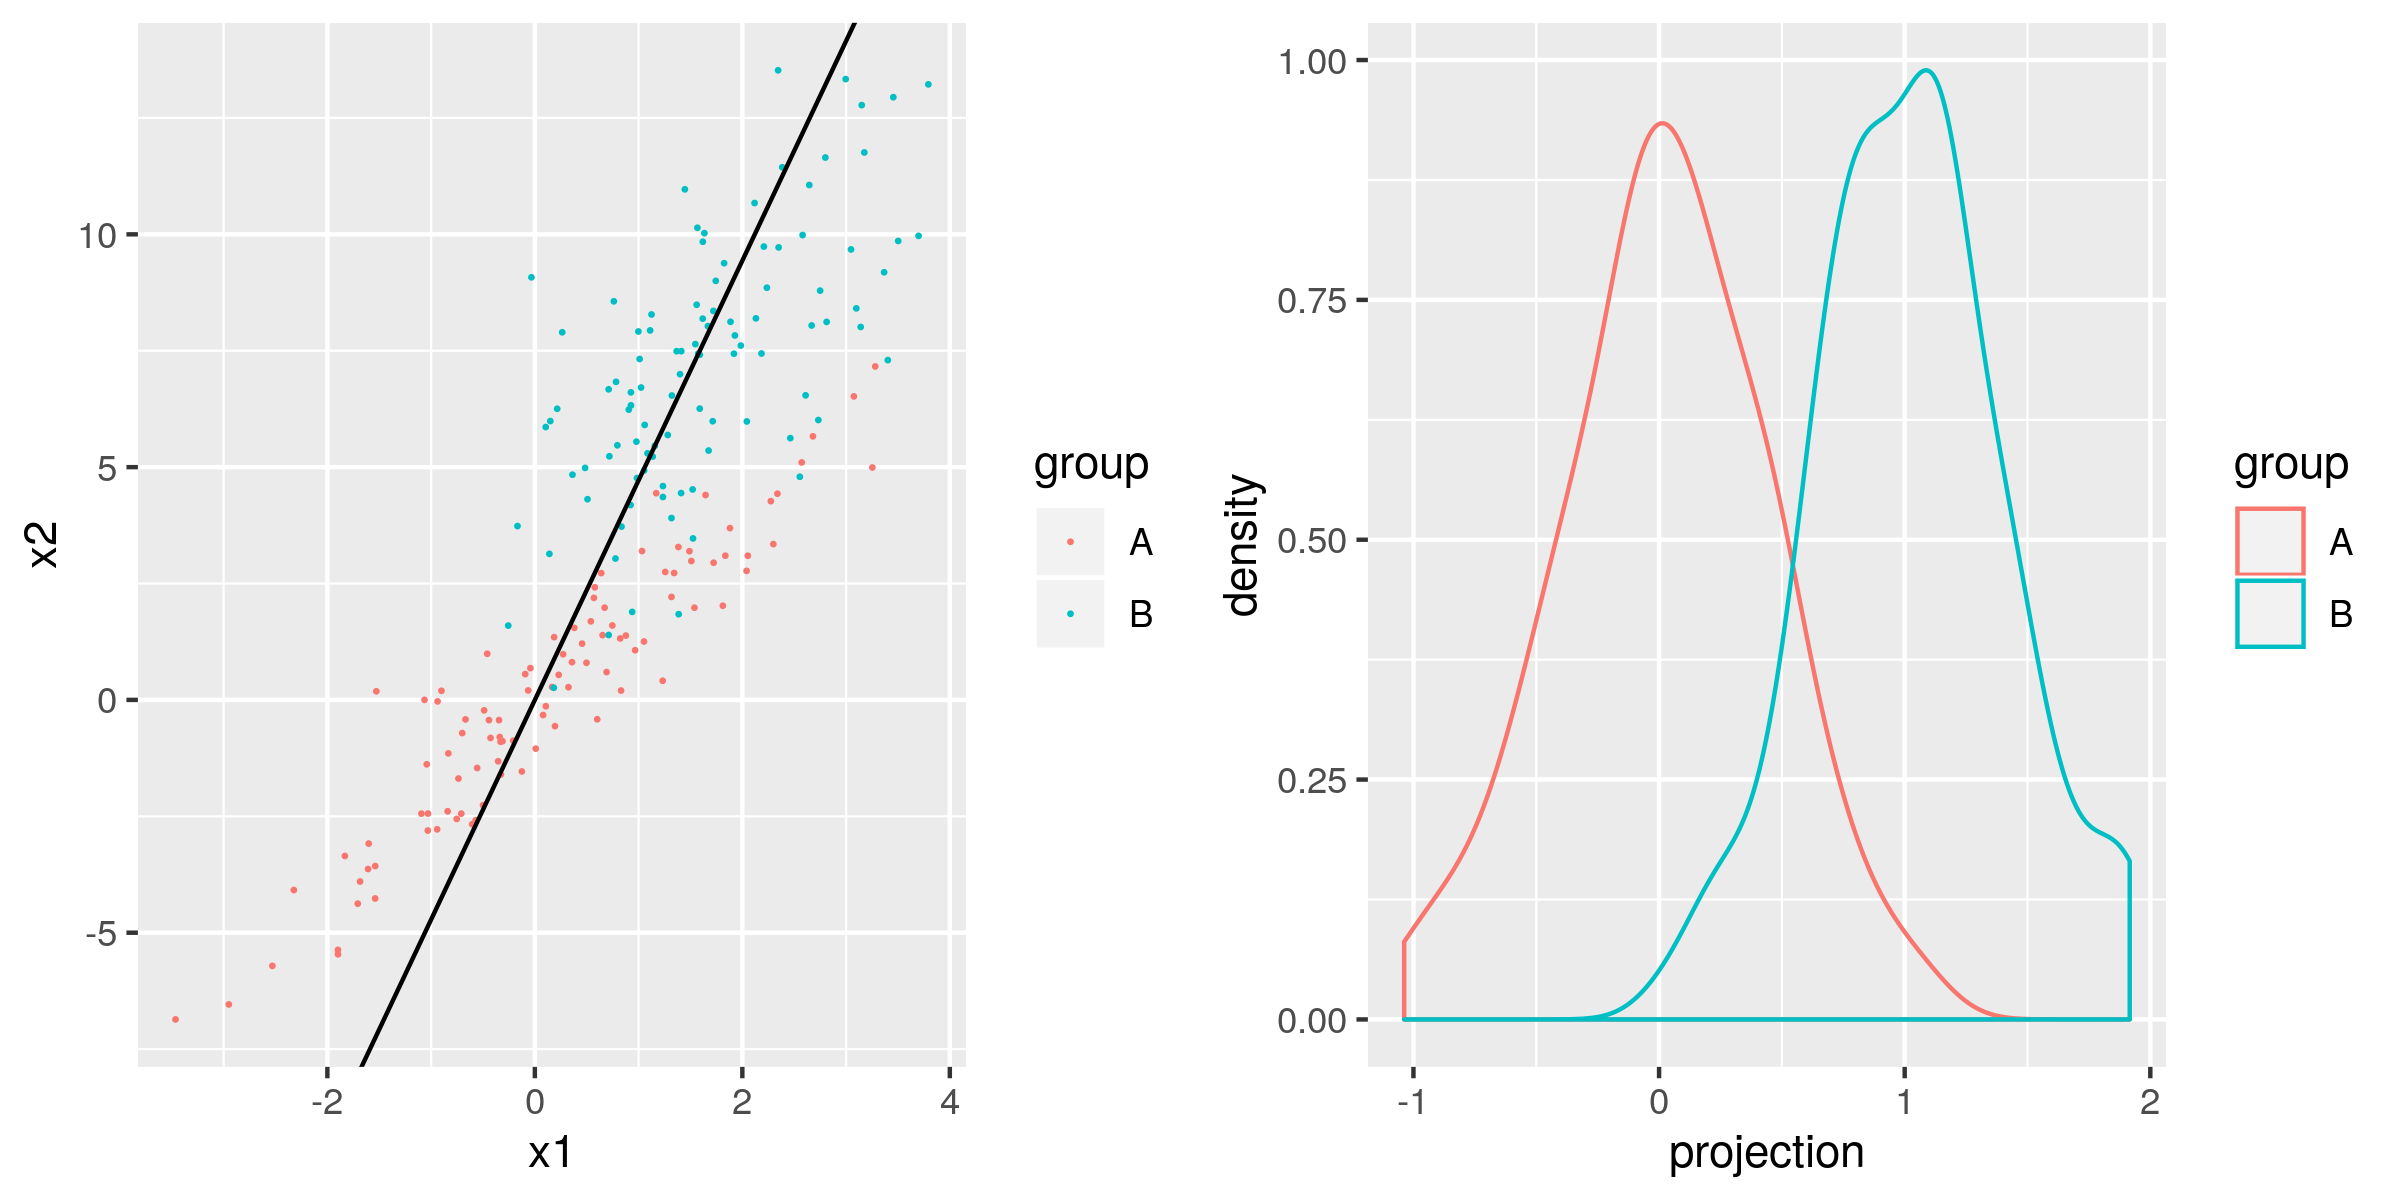

In [9]:
g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])
df$projection<-as.matrix(df[,2:3]) %*% w
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()
ggarrange(g1,g2,ncol = 2)

pr <- prediction(df$projection, df$group)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

Esta, aunque es una solución aparentemente buena no es el óptimo. Fisher lo que busca es el máximo del cociente:
\\[
    J(w)=\frac{\sigma_{entre ~ clases}}{\sigma_{dentro ~ clases}} = \frac{m_B-m_A}{\sigma_{A proyectado}^2+\sigma_{Bproyectado}^2}=\frac{\vec w^T S_{between} \vec w}{\vec w^T S_{within} \vec w}
\\]
Donde $S_{between}$ es la varianza que hay entre clases:
\\[
S_{between} = (\vec m_B - \vec m_A)(\vec m_B - \vec m_A)^T
\\]
Recordemos la fórmula de la covarianza entre dos grupos $x$ e $y$ del módulo de estadística:
\\[
cov(X,Y) = \frac{1}{N} \sum _{i=1}^N \left( x_i-\bar{x} \right)\left( y_i-\bar{y} \right)
\\]
Donde $S_{within}$ es la suma de las varianzas de cada grupo:
\\[
S_{within} = \sum_{n \in C_A} (\vec x_n - m_A)(\vec x_n - m_A)^T + \sum_{n \in C_B} (\vec x_n - m_B)(\vec x_n - m_B)^T
\\]
El mínimo de la función $J(w)$ aparece para un $\vec w$ proporcional a:
\\[
\vec w \propto S_{within}^{-1}(\vec m_B- \vec m_A) 
\\]



In [10]:
mA<-as.matrix(colMeans(subset(df,group=="A")[,c("x1","x2")]))
mB<-as.matrix(colMeans(subset(df,group=="B")[,c("x1","x2")]))

xA<-t(as.matrix(subset(df,group=="A")[,c("x1","x2")]))
xB<-t(as.matrix(subset(df,group=="B")[,c("x1","x2")]))

In [11]:
mA_rep<-matrix(rep(mA,each=ncol(xA)), ncol=ncol(xA), byrow=TRUE)
mB_rep<-matrix(rep(mB,each=ncol(xB)), ncol=ncol(xB), byrow=TRUE)

In [12]:
Sw<-(xA-mA_rep) %*% t(xA-mA_rep)+(xB-mB_rep) %*% t(xB-mB_rep)

In [13]:
w<-solve(Sw) %*% (mB-mA)
w<-w/sqrt(sum(w^2))
w

x1,-0.7841725
x2,0.6205429


[1] "The AUC is 0.9772"

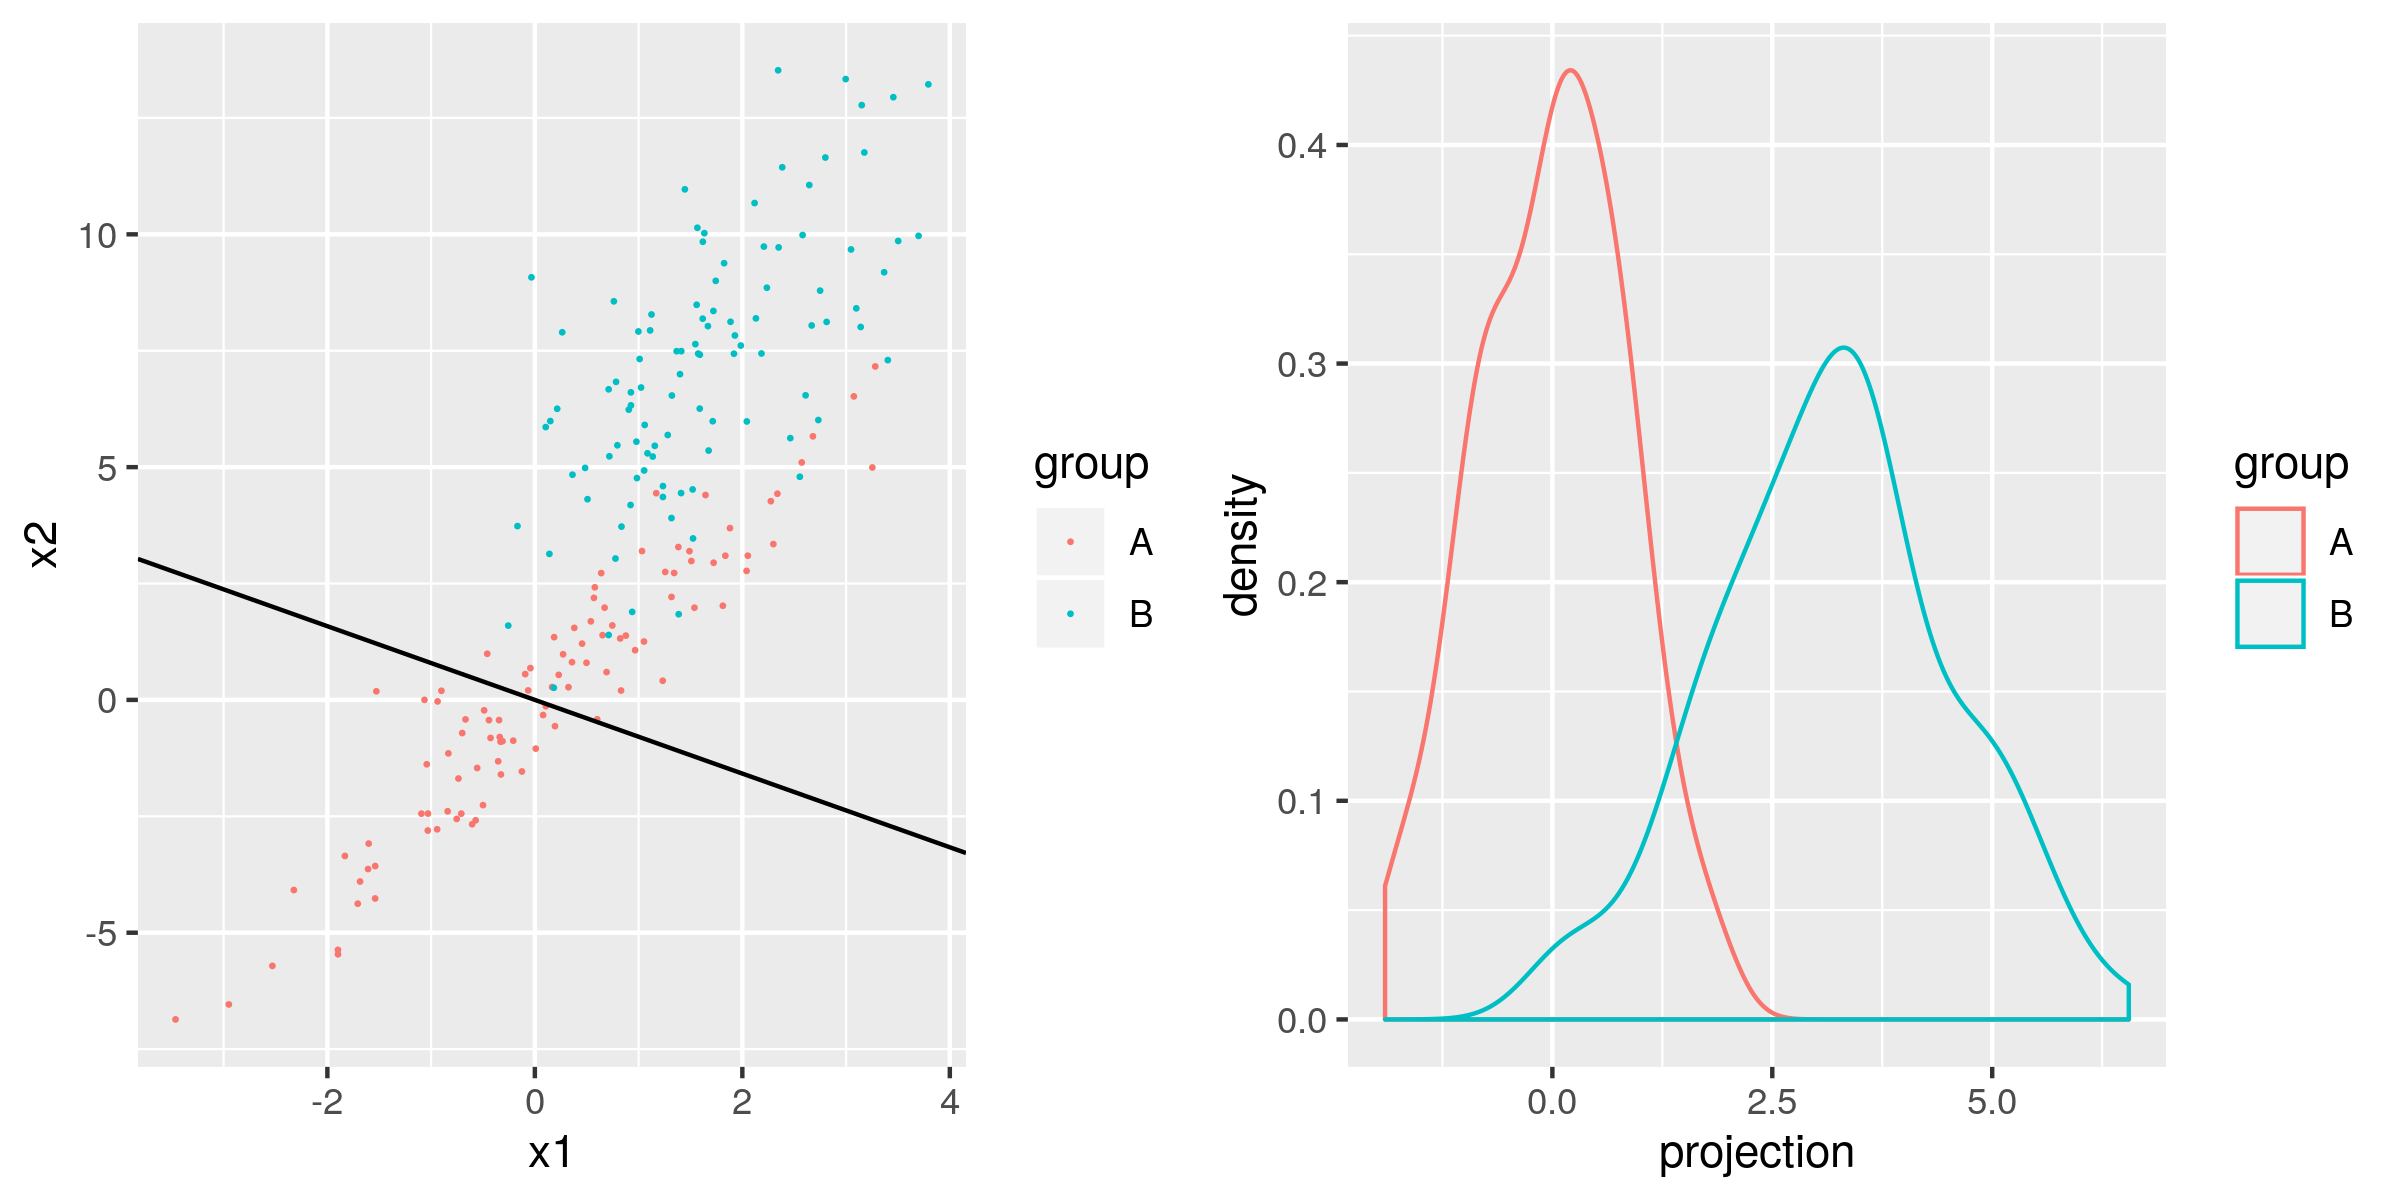

In [14]:
g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])
df$projection<-as.matrix(df[,2:3]) %*% w
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()

ggarrange(g1,g2,ncol = 2)
pr <- prediction(df$projection, df$group)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

En R tenemos la función *lda()* del paquete MASS que nos permite hacer esto mismo de una forma más sencilla:

In [18]:
head(df)

,group,x1,x2,projection
,<fct>,<dbl>,<dbl>,"<dbl[,1]>"
1,A,-0.8407135,-2.3918335,-0.824970962
2,A,-0.3452662,-0.4336488,0.001650616
3,A,2.3380625,4.4294331,0.915209042
4,A,0.1057626,-0.1360174,-0.167340761
5,A,0.1939316,-0.5637554,-0.501910223
6,A,2.5725975,5.1001672,1.147512479


In [17]:
library(MASS)
l<-lda(group~x1+x2,data=df)
l

Call:
lda(group ~ x1 + x2, data = df)

Prior probabilities of groups:
  A   B 
0.5 0.5 

Group means:
         x1        x2
A 0.1356089 0.1636709
B 1.6204651 7.1684844

Coefficients of linear discriminants:
          LD1
x1 -0.6993581
x2  0.5534264

Ambos dan el mismo resultado que teníamos antes:

In [19]:
l$scaling/sqrt(sum(l$scaling^2))
w

,LD1
x1,-0.7841725
x2,0.6205429


x1,-0.7841725
x2,0.6205429


In [22]:
str(l)

List of 10
 $ prior  : Named num [1:2] 0.5 0.5
  ..- attr(*, "names")= chr [1:2] "A" "B"
 $ counts : Named int [1:2] 100 100
  ..- attr(*, "names")= chr [1:2] "A" "B"
 $ means  : num [1:2, 1:2] 0.136 1.62 0.164 7.168
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "A" "B"
  .. ..$ : chr [1:2] "x1" "x2"
 $ scaling: num [1:2, 1] -0.699 0.553
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "x1" "x2"
  .. ..$ : chr "LD1"
 $ lev    : chr [1:2] "A" "B"
 $ svd    : num 20.1
 $ N      : int 200
 $ call   : language lda(formula = group ~ x1 + x2, data = df)
 $ terms  :Classes 'terms', 'formula'  language group ~ x1 + x2
  .. ..- attr(*, "variables")= language list(group, x1, x2)
  .. ..- attr(*, "factors")= int [1:3, 1:2] 0 1 0 0 0 1
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:3] "group" "x1" "x2"
  .. .. .. ..$ : chr [1:2] "x1" "x2"
  .. ..- attr(*, "term.labels")= chr [1:2] "x1" "x2"
  .. ..- attr(*, "order")= int [1:2] 1 1
  .. ..- attr(*, "intercept")

### Comparación con regresión logística

In [23]:
model_glm<-glm(group~x1+x2,data=df,family=binomial)
model_glm
betalg<-model_glm$coefficients


Call:  glm(formula = group ~ x1 + x2, family = binomial, data = df)

Coefficients:
(Intercept)           x1           x2  
     -3.641       -2.206        1.729  

Degrees of Freedom: 199 Total (i.e. Null);  197 Residual
Null Deviance:	    277.3 
Residual Deviance: 71.62 	AIC: 77.62

Recordemos que significaban estos coeficientes:
\\[
log\left( \frac{p_A}{p_B} \right) = \beta_0+\beta_1·x_1+\beta_2·x2   
\\]

El umbral de decisión de una clase u otra lo tenemos en:
\\[
0 = \beta_0+\beta_1·x_1+\beta_2·x2 \\
\beta_2·x2= -\beta_0-\beta_1·x_1 \\
x2= -\frac{\beta_0}{\beta_2}-\frac{\beta_1}{\beta_2}x_1
\\]

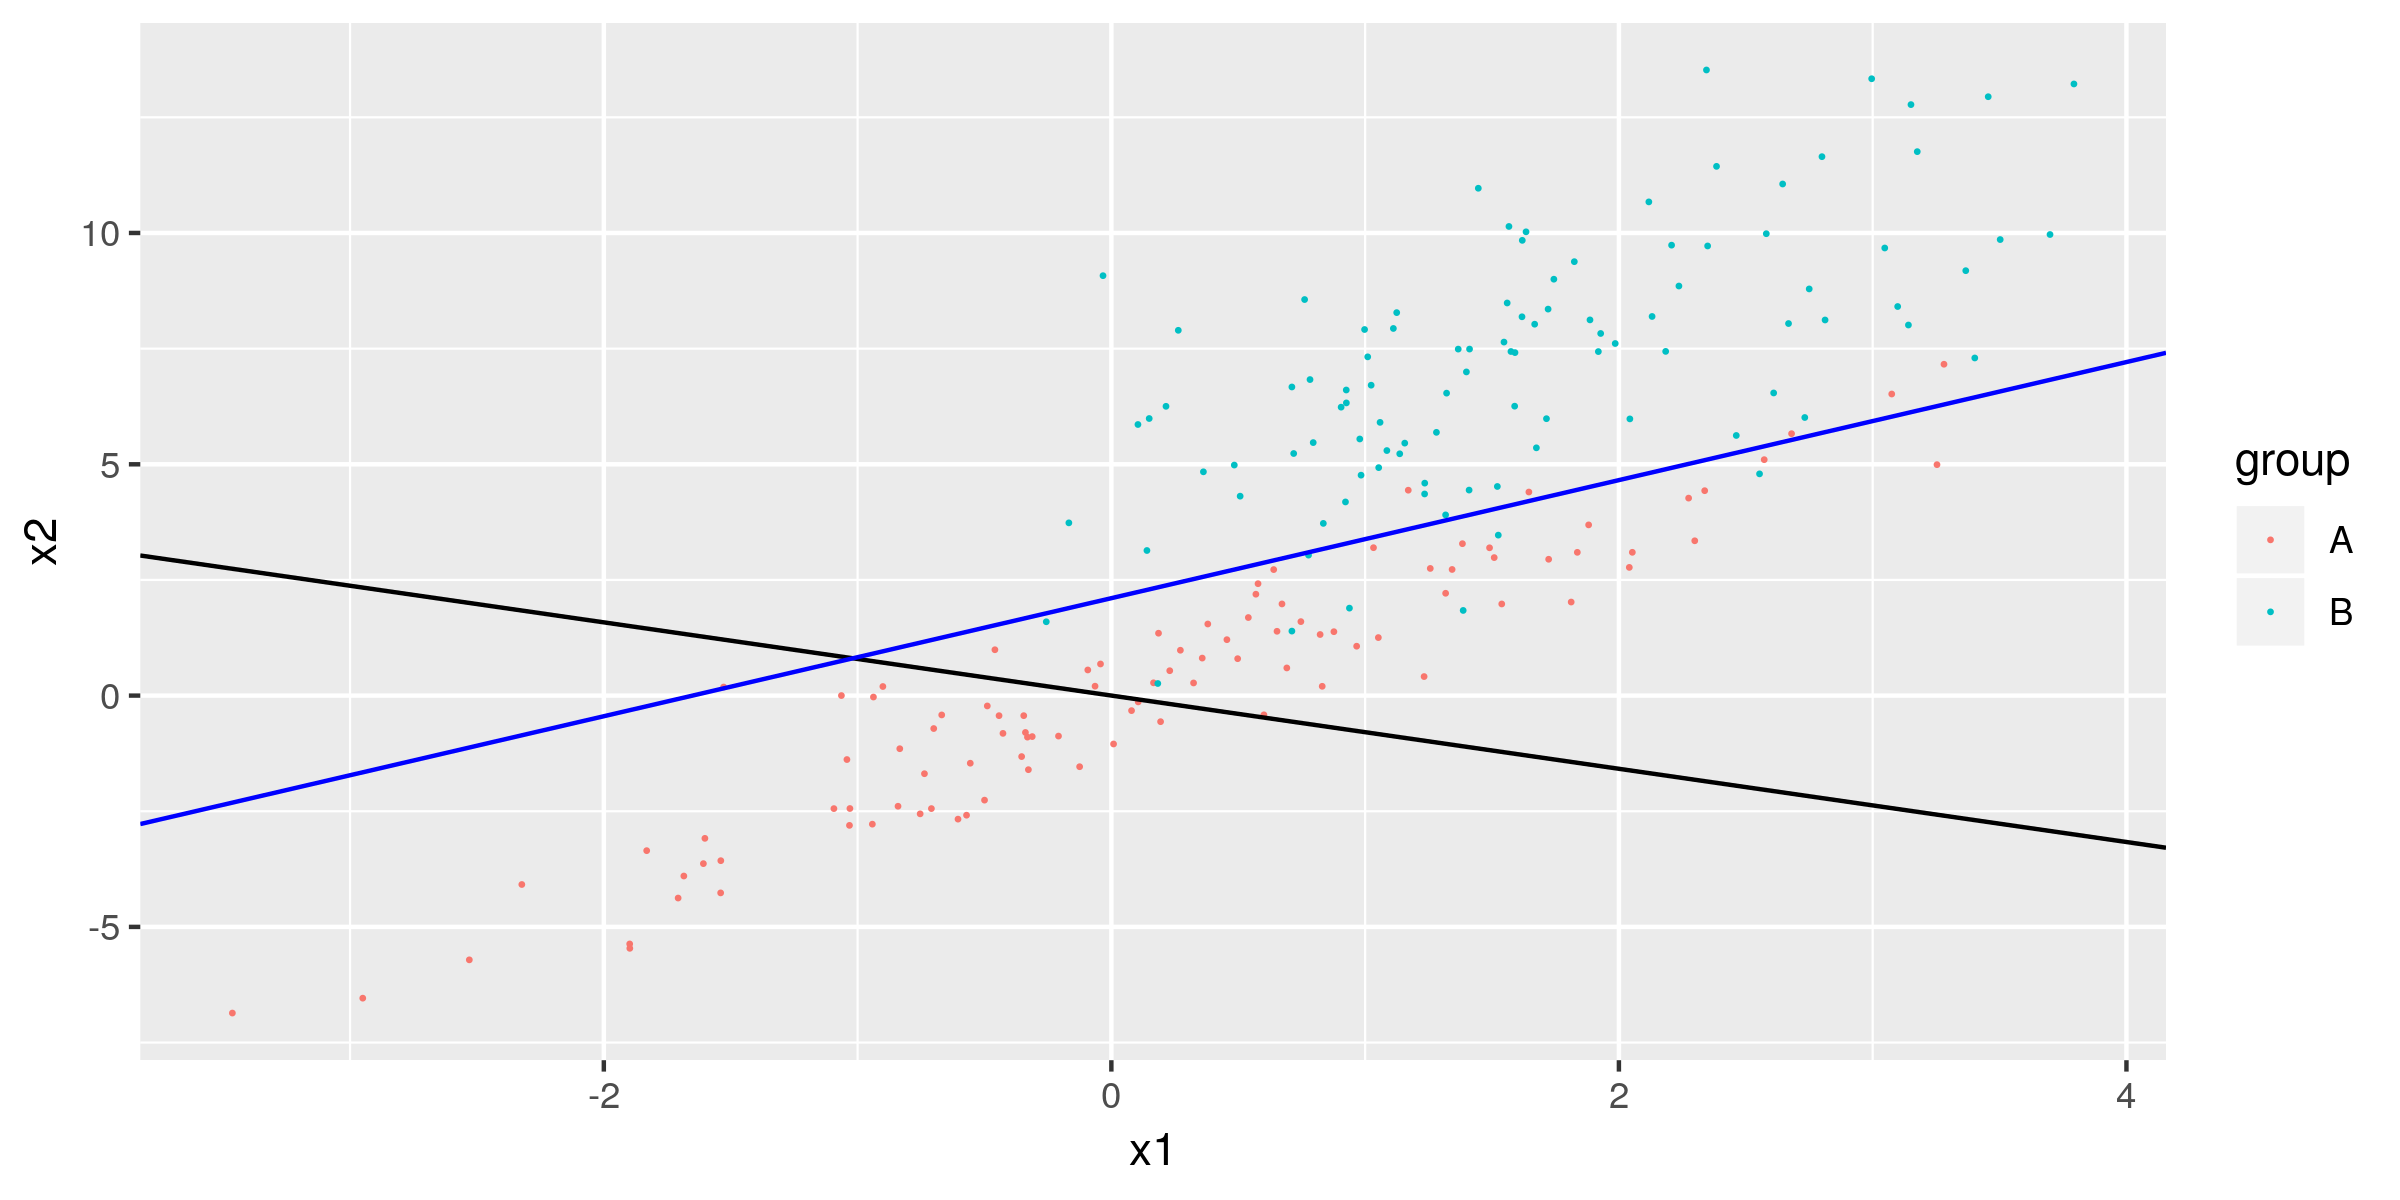

In [28]:
g1<-ggplot(df,aes(x=x1,y=x2,color=group))+geom_point(size=0.1)+geom_abline(slope=w[2]/w[1])+
geom_abline(intercept = -betalg[1]/betalg[3],slope = -betalg[2]/betalg[3], color="blue" )    
g1

Aunque no lo parezca por la perspectiva de la gráfica, ambas rectas son orgonales. El vector que define la pendiente de la curva dada por $\beta$ es el mismo que el vector $\vec w$:

In [30]:
b<-betalg[c("x1","x2")]
b<-b/sqrt(sum(b^2))
b

x1         x2 
-0.7870876  0.6168413

In [31]:
w

x1,-0.7841725
x2,0.6205429


![](#https://media2.giphy.com/media/Z5HVfEvnxr67u/giphy.gif)

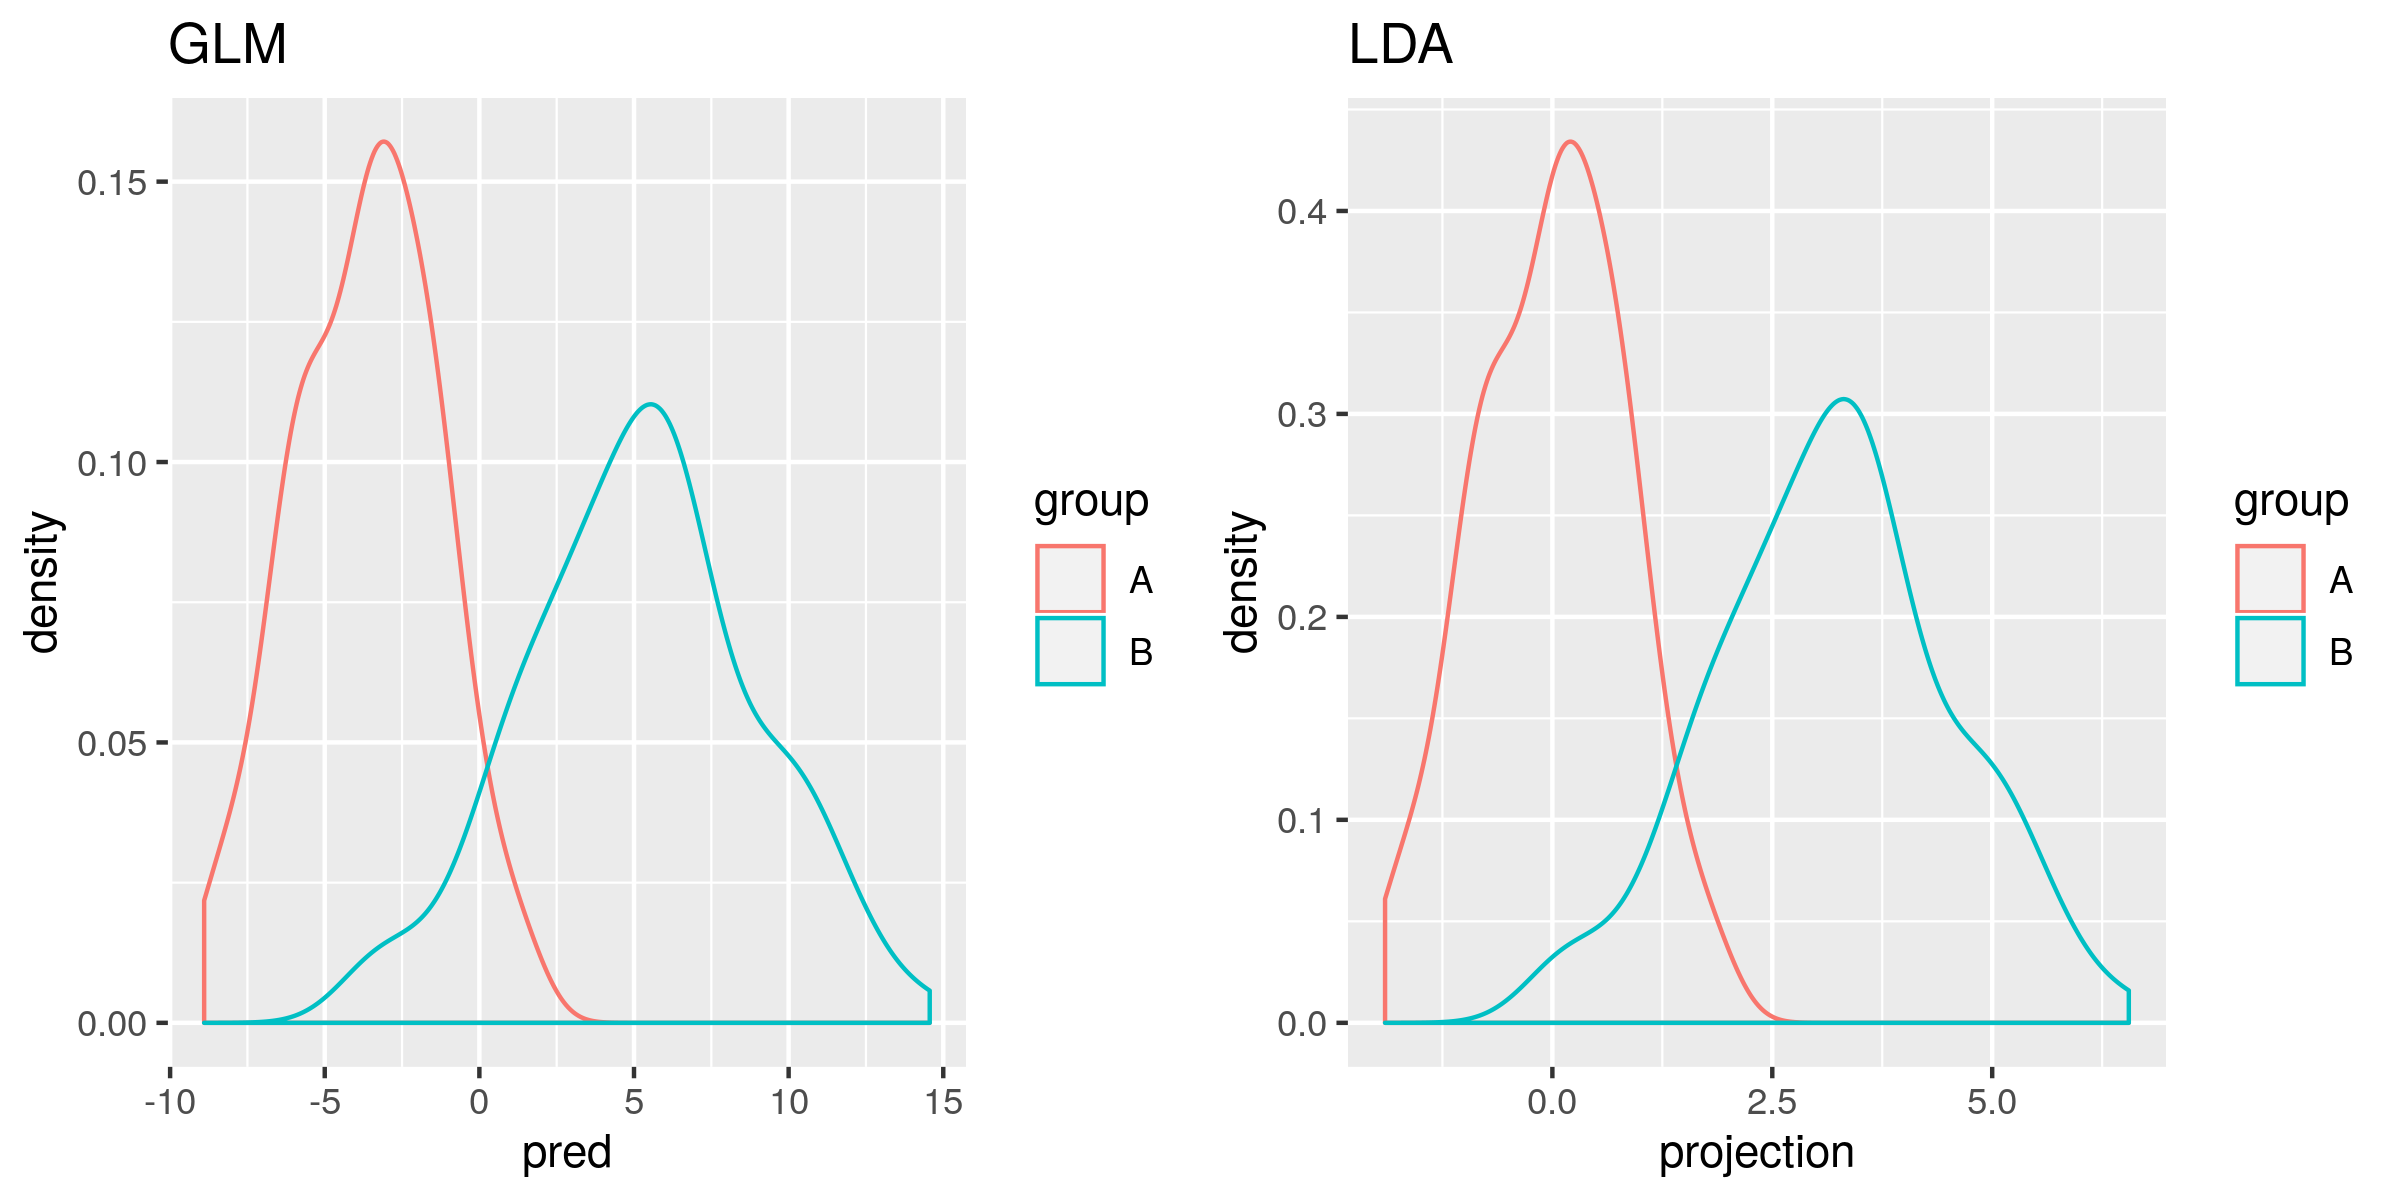

In [32]:
df_glm<-df
df_glm$pred<-predict(model_glm,df)

g1<-ggplot(df_glm,aes(x=pred,color=group))+geom_density()+ggtitle("GLM")
df$projection<-as.matrix(df[,2:3]) %*% w#l$scaling# w
g2<-ggplot(df,aes(x=projection,color=group))+geom_density()+ggtitle("LDA")

ggarrange(g1,g2,ncol = 2)

### Ejemplo Iris

Vamos a utilizar el dataset Iris para ver si somos capaces de diferenciar una clase del resto

In [33]:
idx<-sample(nrow(iris)*0.7)
iris_train<-iris[idx,]
iris_test<-iris[-idx,]

In [39]:
iris_class<-'setosa'
X<-iris[,1:4]
X<-as.matrix(X)
y<-as.matrix(ifelse(iris$Species==iris_class,1,0))

In [40]:
mA<-colMeans(X[y==1,])
mB<-colMeans(X[y==0,])

xA<-t(X[y==1,])
xB<-t(X[y==0,])
      
mA_rep<-matrix(rep(mA,each=ncol(xA)), ncol=ncol(xA), byrow=TRUE)
mB_rep<-matrix(rep(mB,each=ncol(xB)), ncol=ncol(xB), byrow=TRUE)

Sw<-(xA-mA_rep) %*% t(xA-mA_rep)+(xB-mB_rep) %*% t(xB-mB_rep)

In [41]:
Sw

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,49.5838,16.9552,45.6842,17.0550
Sepal.Width,16.9552,18.0024,14.7100,8.3784
Petal.Length,45.6842,14.7100,68.9542,28.8818
Petal.Width,17.0550,8.3784,28.8818,18.4066


In [42]:
w<-solve(Sw) %*% (mB-mA)
w

Sepal.Length,-0.02153031
Sepal.Width,-0.07918534
Petal.Length,0.07325388
Petal.Width,0.01874012


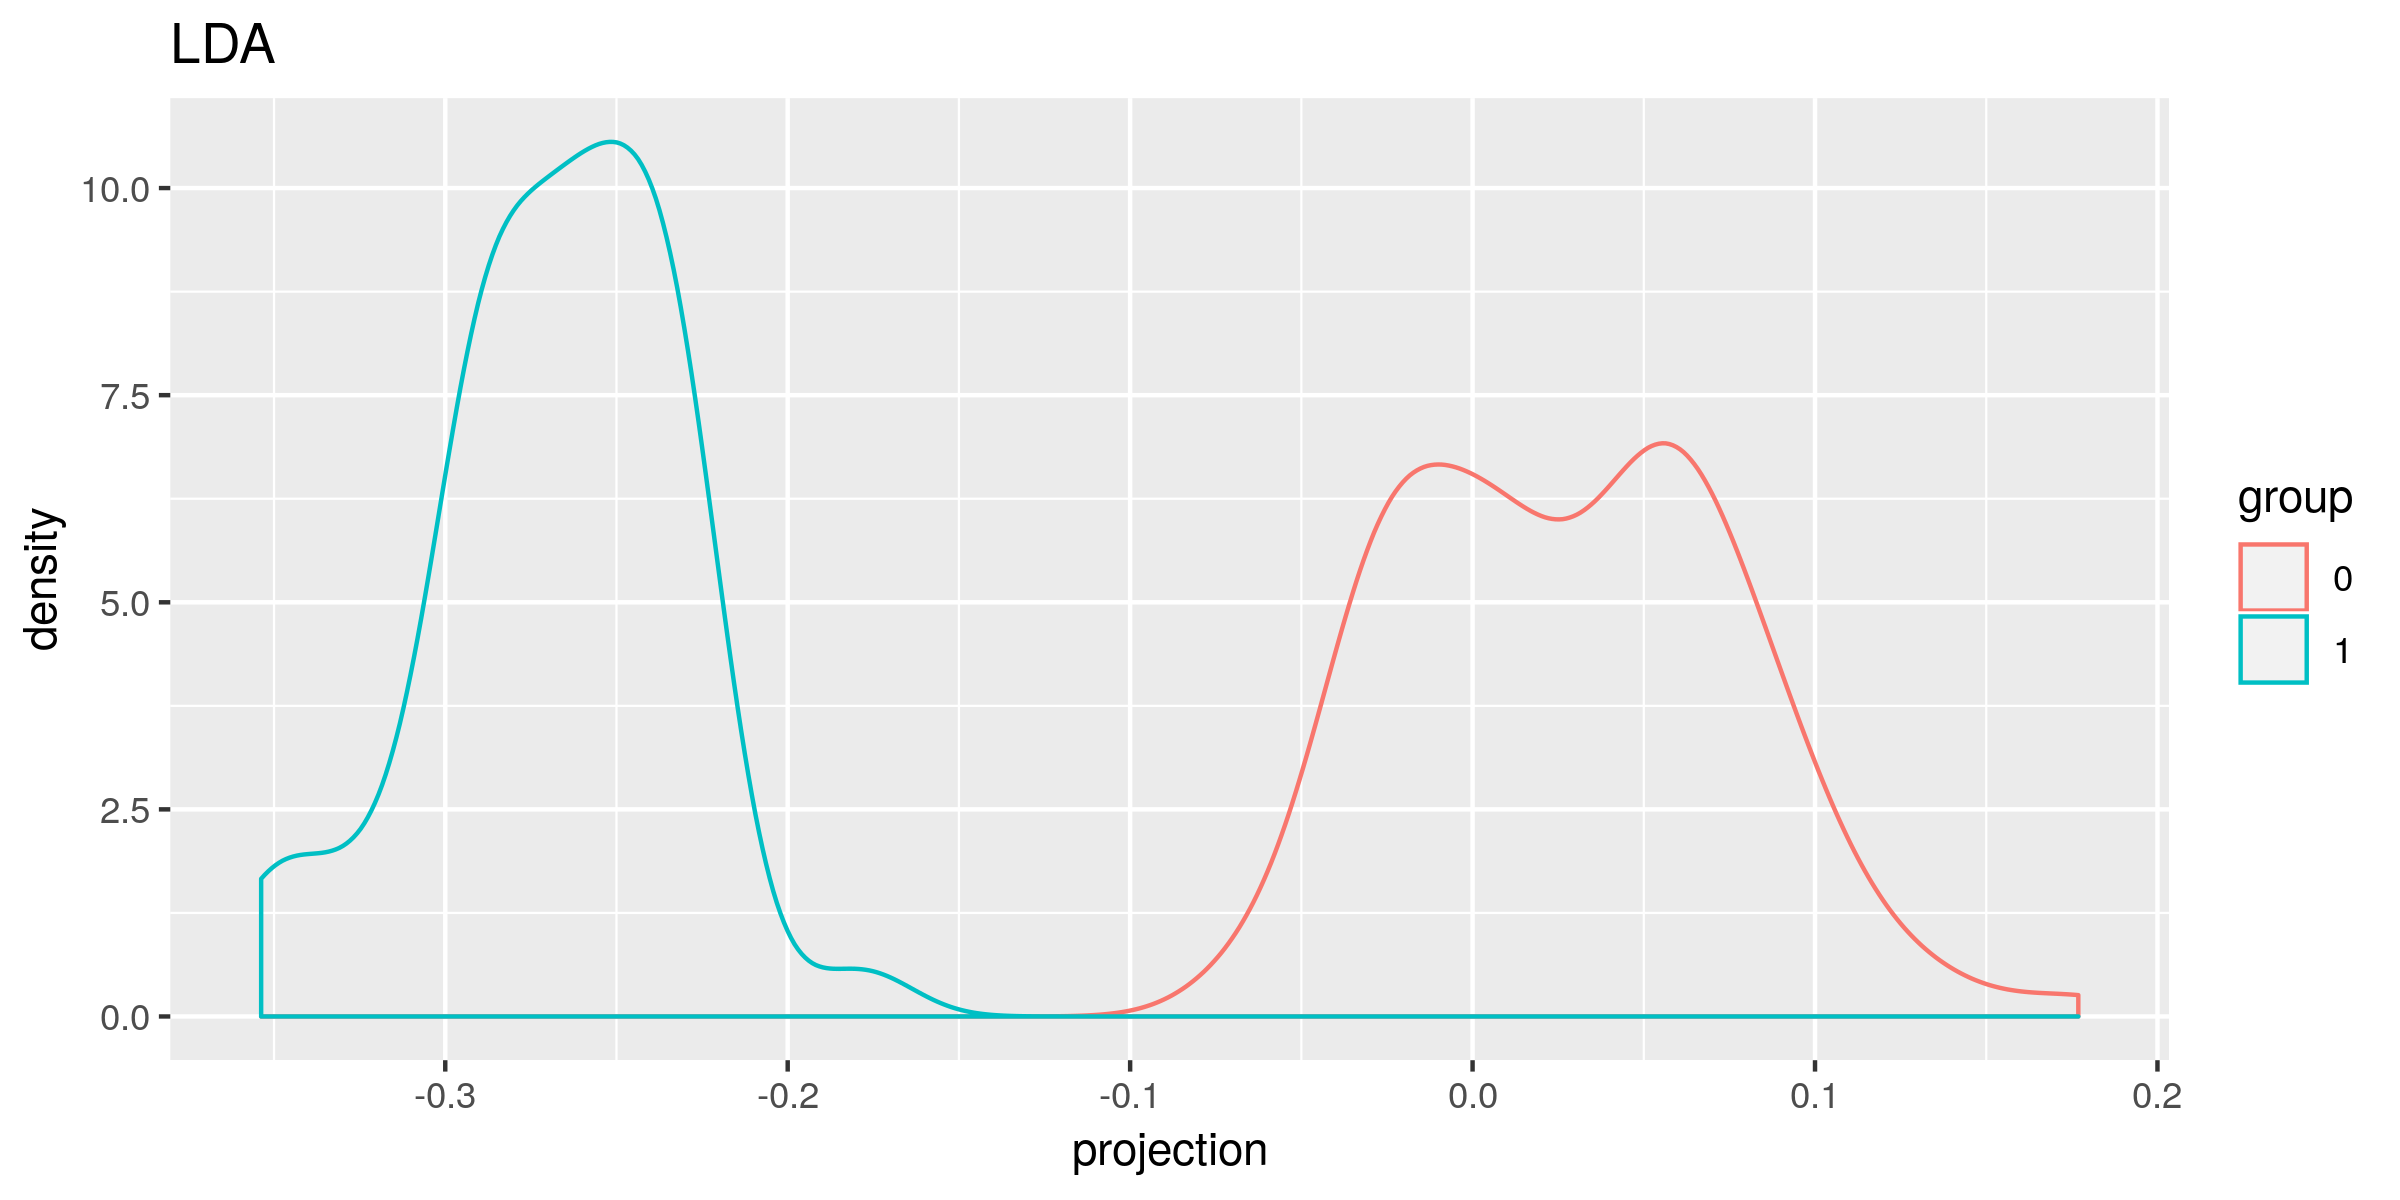

In [43]:
df=data.frame(projection=X %*% w,group=factor(y))
ggplot(df,aes(x=projection,color=group))+geom_density()+ggtitle("LDA")

## LDA para clases múltiples

Consideremos que tenemos dos clases y un vector sobre el que proyectaremos las dos clases, de tal forma que podamos resumir el valor de cada muestra en una sola dimensión. 
\\[
\vec y = X · \vec{w}
\\]
Donde
* X son los datos que queremos clasificar $X \in \mathbb{R}^{N\times p}$
* w es el vector de proyección, $w \in \mathbb{R}^{p\times1}$
* y son los datos proyectados, $y \in \mathbb{R}^{N\times1}$

Podemos generalizar a $K$ clases el problema suponiendo que $y$ tiene más columnas, una por cada clase que queremos clasificar:
\\[
\vec y_k = X · \vec{w_k}
\\]
* $w_k$ es el vector de proyección, $w \in \mathbb{R}^{p\times1}$ que diferencia la clase $k$ del resto
* $y_k$ son los datos proyectados que maximizan la separación entre la clase $k$ y el resto, $y_k \in \mathbb{R}^{N\times1}$

Podemos crear la matrix $Y$ combinando todas las $y_k$:
\\[
\vec Y = X · W
\\]
* $W$ es la matriz de proyección, $w \in \mathbb{R}^{p\times K}$
* $Y$ son los datos proyectados de tal forma que cada columa $k$ maximiza la separación entre la clase $k$ y el resto, $Y \in \mathbb{R}^{N\times K}$

Recordemos que Fisher lo que busca es el máximo del cociente:
\\[
    J(w)=\frac{\sigma_{entre ~ clases}}{\sigma_{dentro ~ clases}} =\frac{ |\vec w^T S_{between} \vec w|}{|\vec w^T S_{within} \vec w |}  = Tr \left\{ \left( \vec w^T S_{within} \vec w \right)^{-1} \left( \vec w^T S_{between} \vec w \right) \right\}
\\]

Definimos la media global y para cada clase:
\\[
\vec \mu= \frac{1}{N}\sum_{i\in N} x_i ~~~~~~~~~ \vec \mu \in \mathbb{R}^{p\times 1}\\
\vec \mu_k= \frac{1}{N_k}\sum_{i\in C_k} x_i  ~~~~~~~~~  \vec \mu_k \in \mathbb{R}^{p\times 1}
\\]

Donde $S_{between}$ es la varianza que hay entre clases. Como se separa cada clase de la media global.

Para dos clases era:
\\[
S_{between} = (\vec m_B - \vec m_A)(\vec m_B - \vec m_A)^T
\\]
La generalización para K clases es:
\\[
S_{between} = \sum_{k=1}^K N_k (\vec \mu_k - \vec \mu)(\vec \mu_k - \vec \mu)^T ~~~~~~~~~ S_{between} \in \mathbb{R}^{p\times p}\\
\\]


Donde $S_{within}$ es la suma de las varianzas de cada grupo. Como varían las muestras dentro de cada clase:

Para dos clases era:
\\[
S_{within} = \sum_{n \in C_A} (\vec x_n - m_A)(\vec x_n - m_A)^T + \sum_{n \in C_B} (\vec x_n - m_B)(\vec x_n - m_B)^T
\\]
La generalización para K clases es:
\\[
S_{within} = \sum_{k=1}^K \sum_{i\in C_k} (\vec x_i - \vec \mu_k)(\vec x_i - \vec \mu_k)^T ~~~~~~~~~\vec x_i \in \mathbb{R}^{p\times 1} ~~~  S_{within} \in \mathbb{R}^{p\times p}\\
\\]

El máximo de J(w) se consigue cuando:
\\[
S_{between}·W = \lambda S_{within} · W \\
 S_{within}^{-1} S_{between} W = \lambda W
\\]
La solución viene dada por los autovectores, de cuyos K-1 autovalores son mayores.

In [44]:
idx<-sample(1:nrow(iris),nrow(iris)*0.7)
iris_train<-iris[idx,]
iris_test<-iris[-idx,]

X<-iris_train[,1:4]
X<-as.matrix(X)
Cl<-iris_train$Species
p<-ncol(X)

In [45]:
table(Cl)

Cl
    setosa versicolor  virginica 
        36         37         32 

In [46]:
mu<-colMeans(X)
Sb=matrix(0L, nrow = p, ncol = p) 
for (k in levels(Cl)){
    mu_k=colMeans(X[Cl==k,])
    N_k=sum(Cl==k)
    Sb=Sb+N_k*(mu_k-mu) %*% t(mu_k-mu)
}
Sb

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
45.94583,-13.80808,118.77333,51.47963
-13.80808,6.21327,-36.90709,-14.81535
118.77333,-36.90709,307.74985,132.69337
51.47963,-14.81535,132.69337,57.88835


In [47]:
Sw<-matrix(0L, nrow=p, ncol=p)
for (k in levels(Cl)){
    X_k<-X[Cl==k,]
    mu_k=colMeans(X[Cl==k,])
    for (i in 1:nrow(X_k)){
        X_i<-as.matrix(X_k[i,])        
        Sw<-Sw+(X_i-mu_k) %*% t(X_i-mu_k)
    }
}
Sw

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,24.896456,7.464655,15.037237,3.422372
Sepal.Width,7.464655,10.451873,3.816235,2.917350
Petal.Length,15.037237,3.816235,17.828630,4.201299
Petal.Width,3.422372,2.917350,4.201299,3.752988


In [48]:
#Se puede calcular Sw de una forma más eficiente pensando :

Sw<-matrix(0L, nrow=p, ncol=p)
for (k in levels(Cl)){
    X_k<-X[Cl==k,]
    mu_k=colMeans(X[Cl==k,])
    
    mu_krep<-matrix(rep(mu_k,each=nrow(X_k)), ncol=nrow(X_k), byrow=TRUE)
    X_k<-t(as.matrix(X_k))
    Sw<-Sw+(X_k-mu_krep) %*% t(X_k-mu_krep)
    
}
Sw

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,24.896456,7.464655,15.037237,3.422372
Sepal.Width,7.464655,10.451873,3.816235,2.917350
Petal.Length,15.037237,3.816235,17.828630,4.201299
Petal.Width,3.422372,2.917350,4.201299,3.752988


In [49]:
(solve(Sw) %*% Sb)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,-2.347272,0.7251209,-6.07944,-2.623722
Sepal.Width,-5.662928,1.8918041,-14.75065,-6.284621
Petal.Length,6.899924,-2.2466980,17.93847,7.675961
Petal.Width,12.535336,-3.5643567,32.28558,14.109592


In [50]:
eig<-eigen(solve(Sw) %*% Sb)
eig

eigen() decomposition
$values
[1] 3.128425e+01 3.083516e-01 3.553641e-15 2.276375e-16

$vectors
           [,1]         [,2]       [,3]       [,4]
[1,] -0.1510477 -0.000438337  0.1023919 -0.9259546
[2,] -0.3661070 -0.398870085 -0.4890764  0.0486118
[3,]  0.4453837  0.323007834 -0.4238822  0.2388154
[4,]  0.8029842 -0.858235633  0.7554098  0.2884653


Realmente la proyección óptima debería ser sobre K-1, es decir 2 columnas. 
Con los dos primeros autovectores podríamos definir bien las fronteras de las 3 clases:

In [51]:
W<-Re(eig$vectors[,1:2])
head(X %*% W)

66,0.9369151,-1.0197295
70,0.8591446,-0.6839585
110,2.3187727,-1.6143296
59,1.0340196,-0.7894866
9,-0.9421861,-0.8780881
23,-1.4068240,-1.2865879


In [52]:
library(MASS)
l<-lda(formula=Species ~ Sepal.Length+Sepal.Width+Petal.Length+Petal.Width, data=iris_train)
l

Call:
lda(Species ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width, 
    data = iris_train)

Prior probabilities of groups:
    setosa versicolor  virginica 
 0.3428571  0.3523810  0.3047619 

Group means:
           Sepal.Length Sepal.Width Petal.Length Petal.Width
setosa         4.944444    3.361111     1.438889   0.2388889
versicolor     6.008108    2.791892     4.335135   1.3513514
virginica      6.550000    2.956250     5.543750   2.0625000

Coefficients of linear discriminants:
                    LD1         LD2
Sepal.Length  0.6257743  0.00198519
Sepal.Width   1.5167421  1.80644788
Petal.Length -1.8451770 -1.46287435
Petal.Width  -3.3266772  3.88687444

Proportion of trace:
   LD1    LD2 
0.9902 0.0098 

In [53]:
W
l$scaling / sqrt(colSums(l$scaling^2))

-0.1510477,-0.000438337
-0.3661070,-0.398870085
0.4453837,0.323007834
0.8029842,-0.858235633


,LD1,LD2
Sepal.Length,0.1510477,0.0004791797
Sepal.Width,0.3349020,0.3988700849
Petal.Length,-0.4453837,-0.3531045804
Petal.Width,-0.7345421,0.8582356335


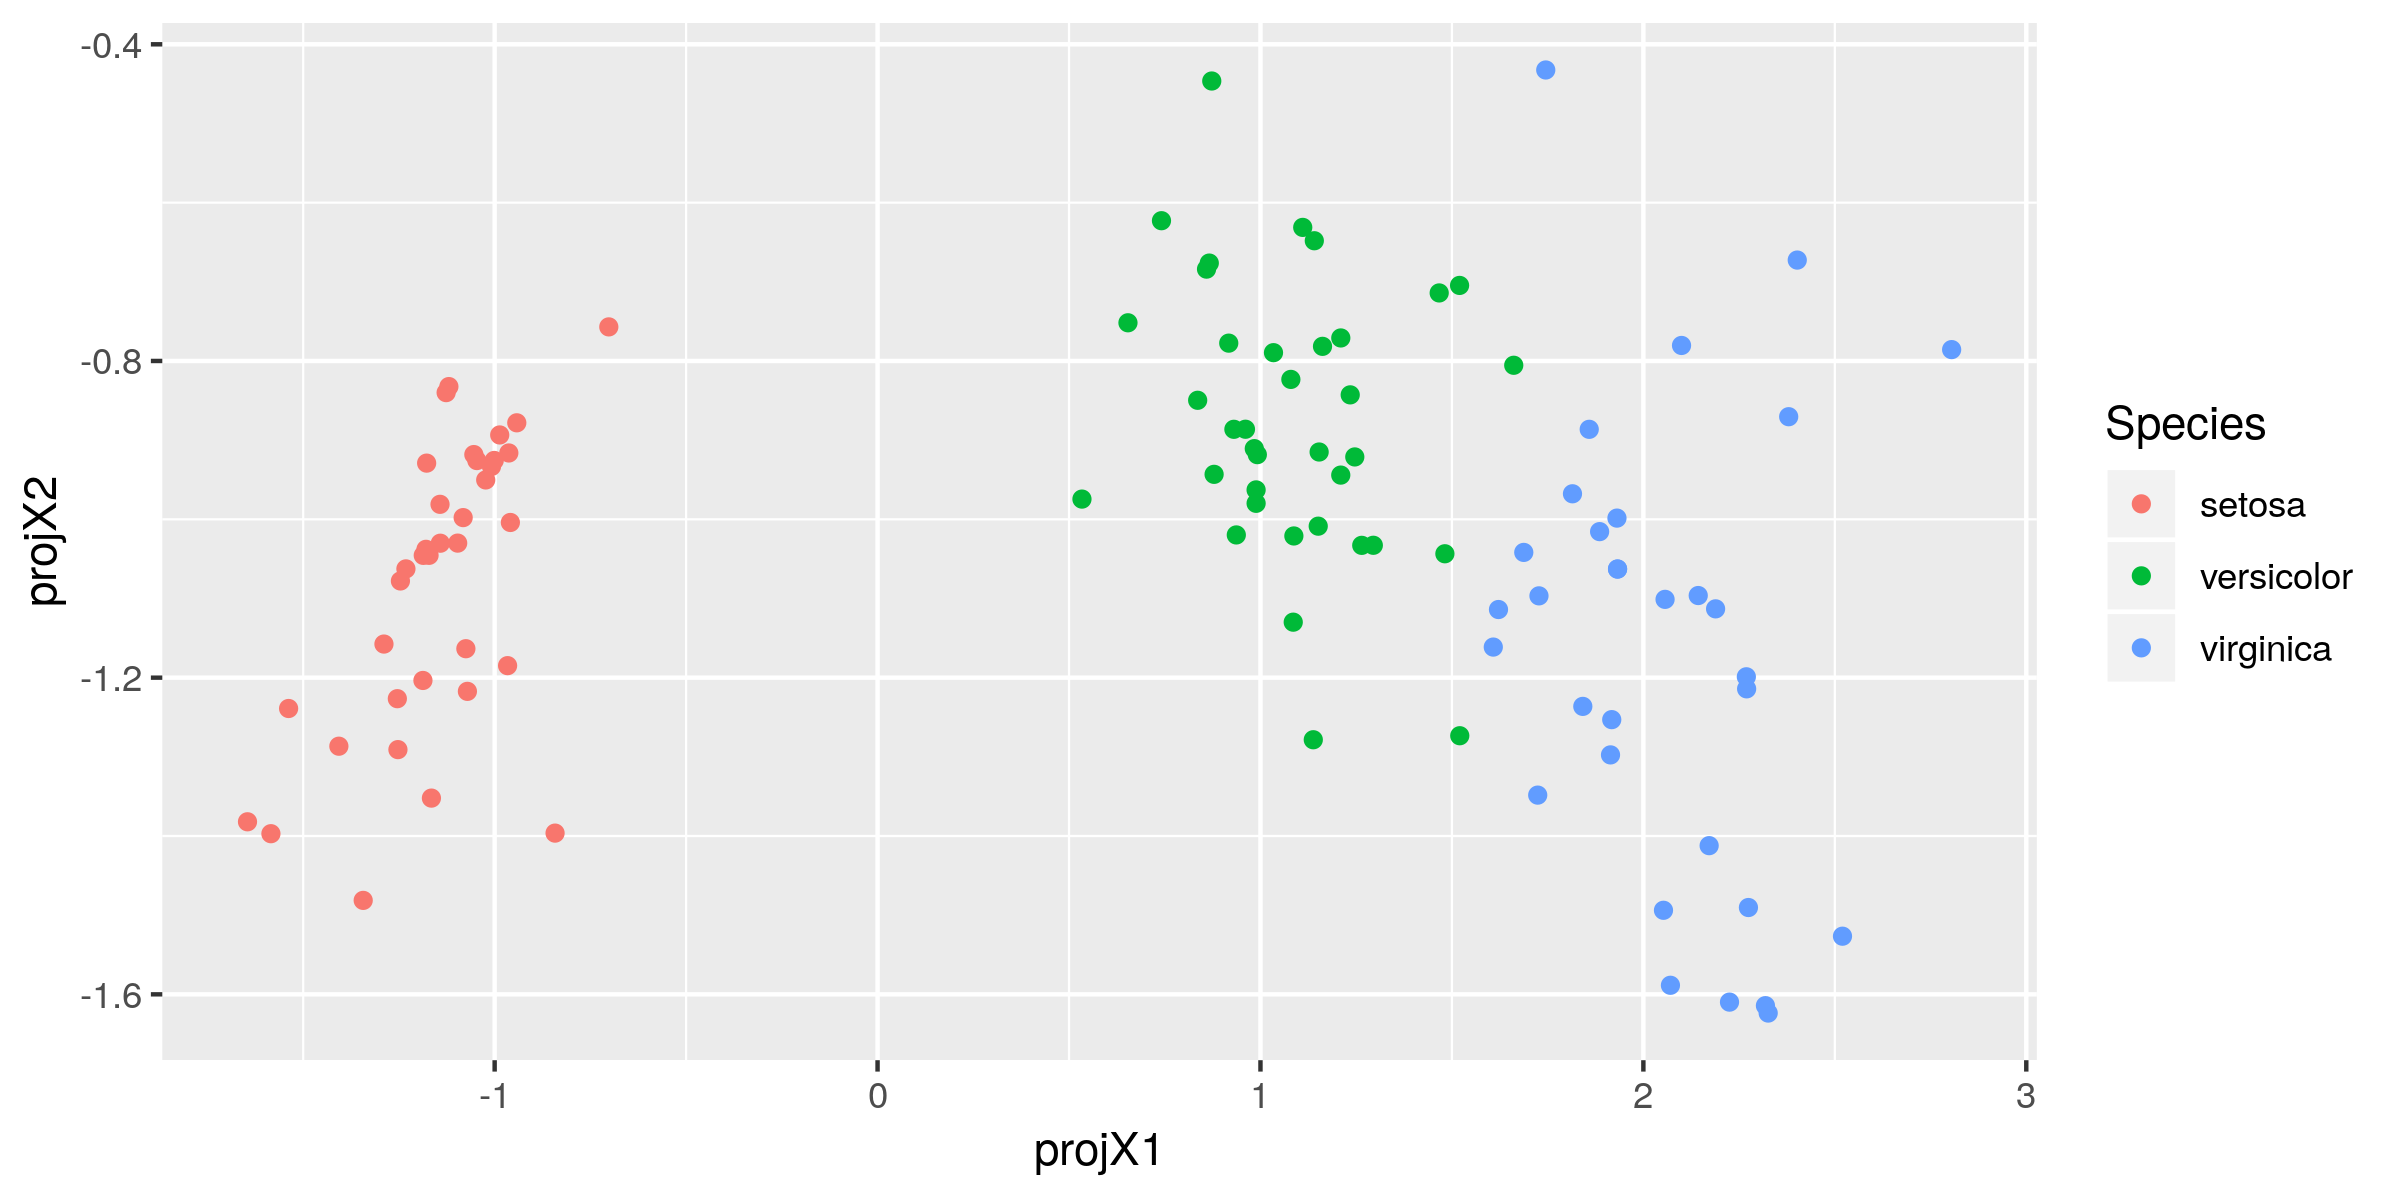

In [54]:
W<-eig$vectors[,1:2]
iris_train[,c("projX1","projX2")]<-Re(X %*% W)
ggplot(iris_train,aes(x=projX1,y=projX2,color=Species))+geom_point()

Como vemos, el mayor poder discriminante se encuenta en la primera proyección que es la que corresponde al autovalor más grande. Esto tiene sentido porque el primer autovector es 100 veces más grande que el segundo. Esto indica que la primera dimensión tiene casi todo el poder discriminante.

Podemos comprobarlo proyectando solo sobre el primer discrimante:

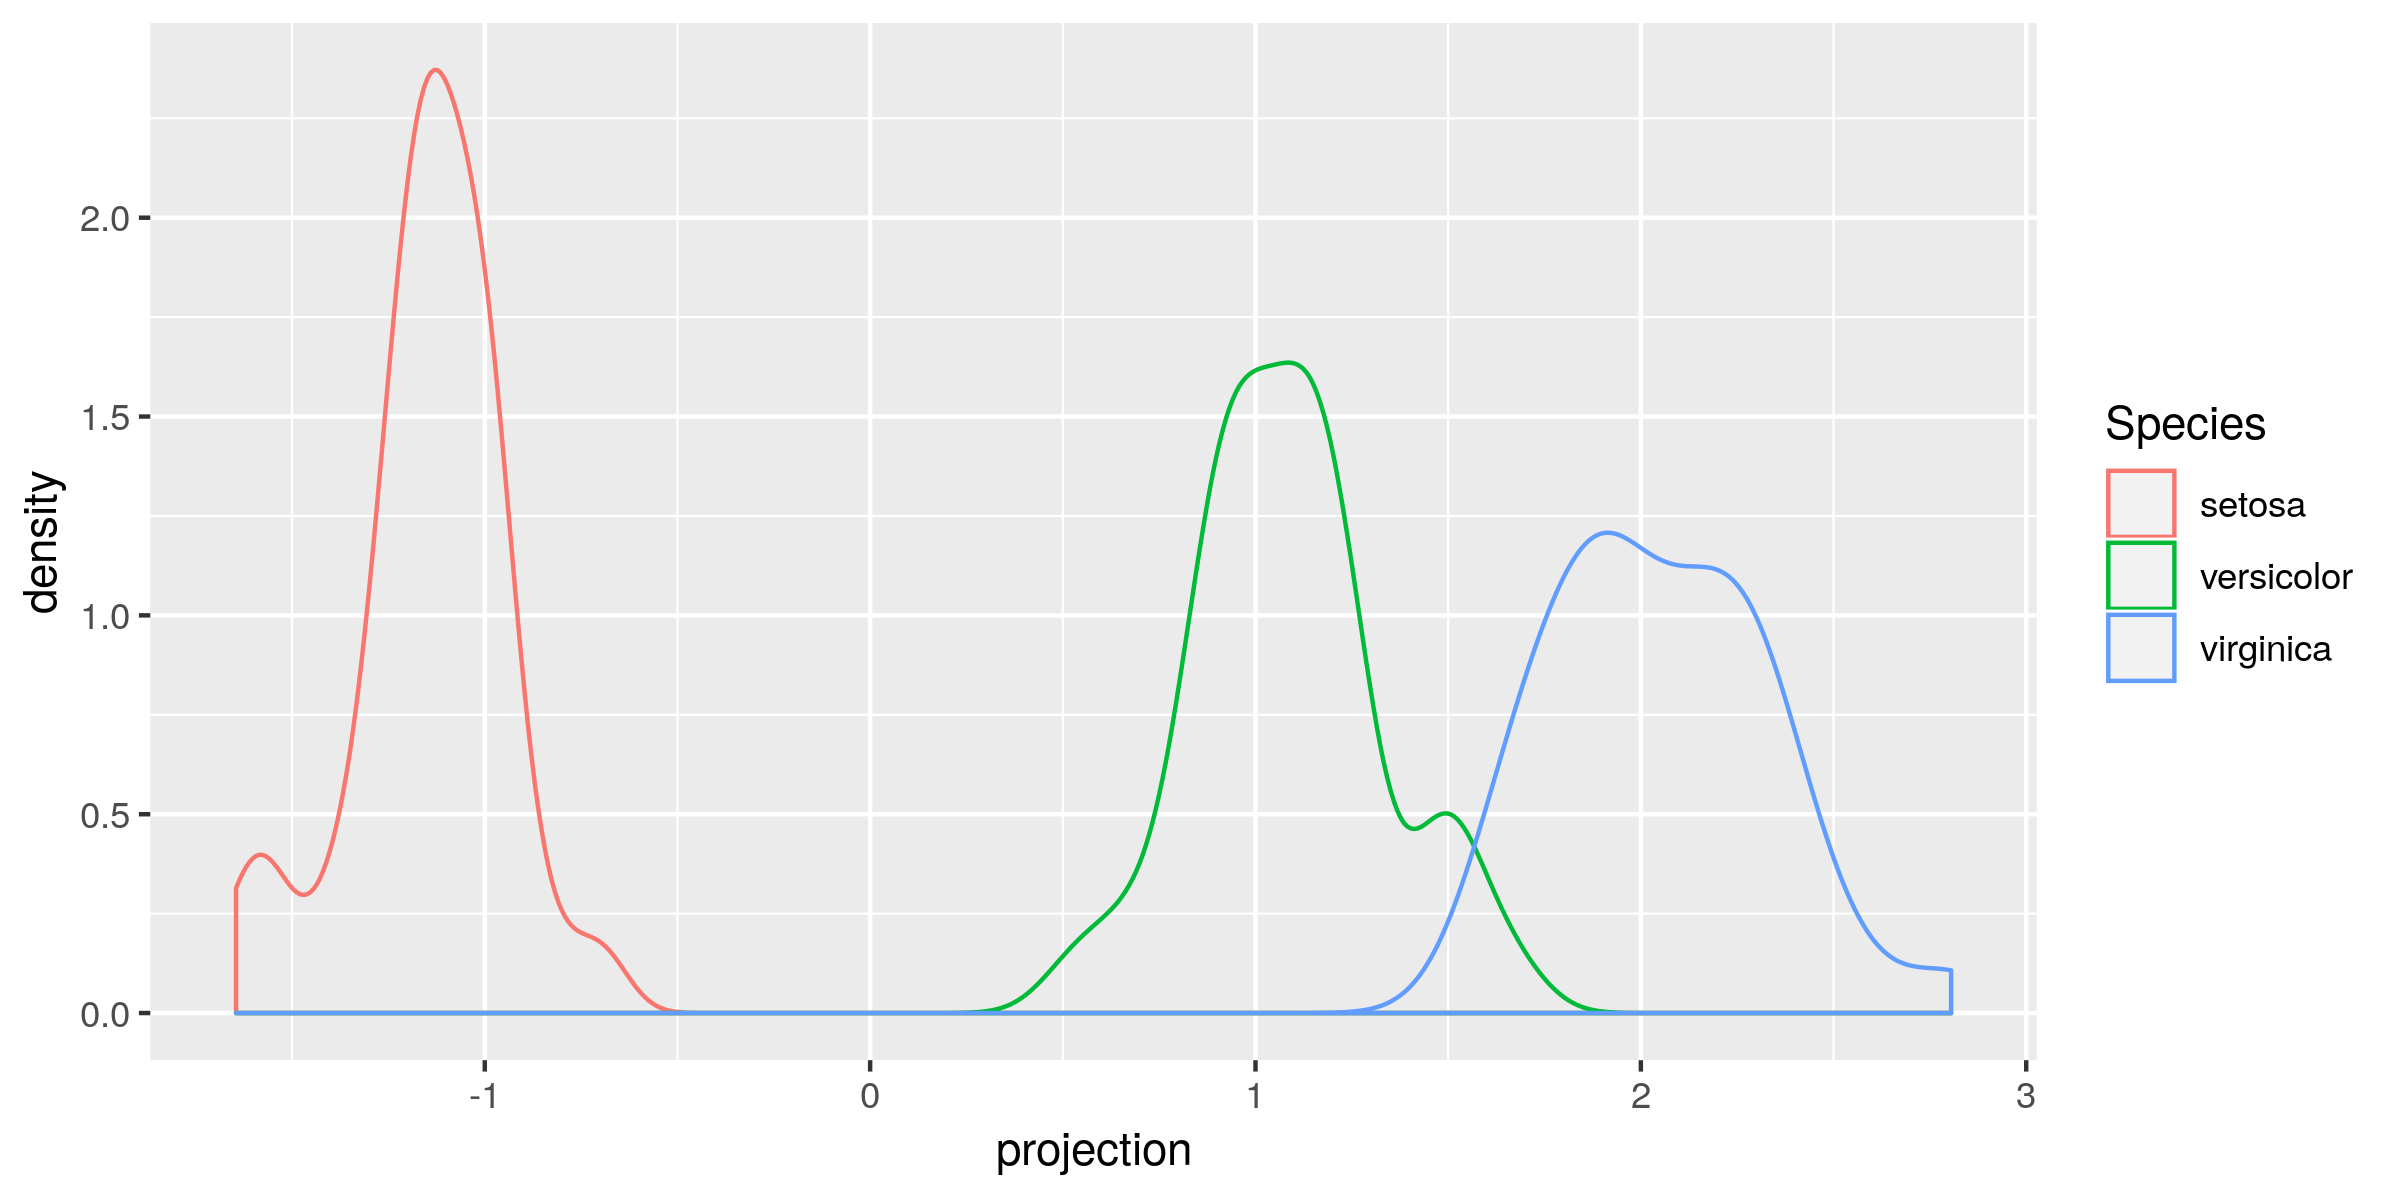

In [55]:
W<-eig$vectors[,1]
iris_train$projection <- Re(X %*% W)
ggplot(iris_train,aes(x=projection,color=Species))+geom_density()

Para el conjunto de training:

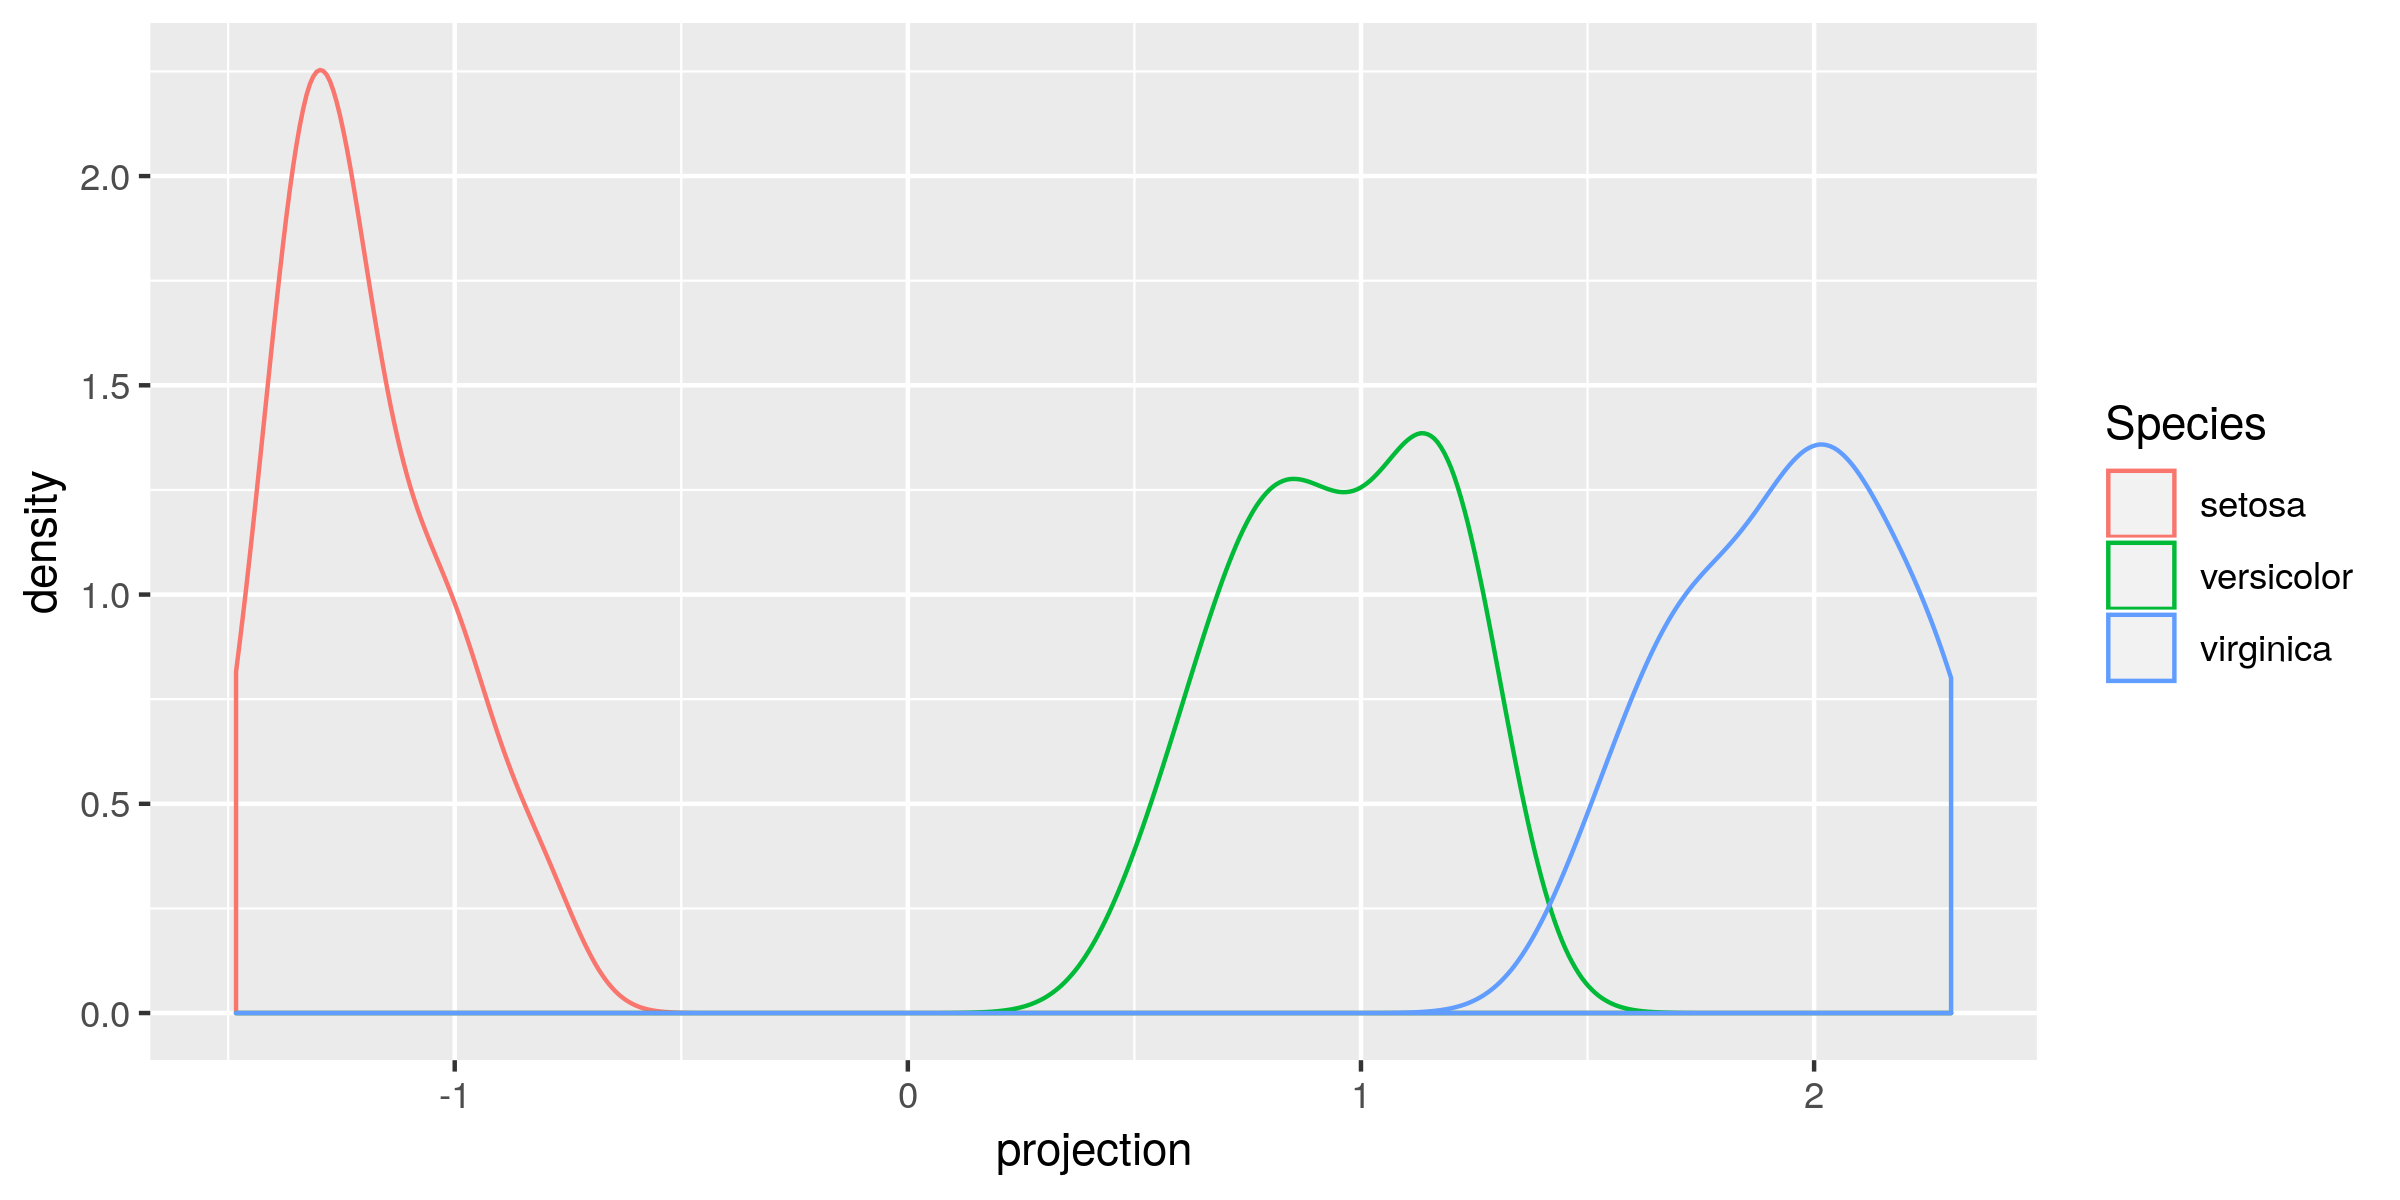

In [56]:
X_test<-as.matrix(iris_test[,1:4])
iris_test$projection <- Re(X_test %*% W)
ggplot(iris_test,aes(x=projection,color=Species))+geom_density()

In [62]:
lda_pred <- predict(l, iris_test)
head(lda_pred)

,setosa,versicolor,virginica
1,1.000000e+00,1.454432e-21,7.804370e-42
11,1.000000e+00,6.985873e-23,1.450383e-43
12,1.000000e+00,1.583505e-18,7.869846e-38
16,1.000000e+00,4.641267e-26,1.303713e-46
22,1.000000e+00,8.947161e-20,1.549551e-38
24,1.000000e+00,2.878125e-14,4.194922e-31
26,1.000000e+00,2.673299e-16,3.594261e-35
28,1.000000e+00,5.149201e-21,3.728285e-41
37,1.000000e+00,2.276696e-23,2.587174e-44
38,1.000000e+00,6.396009e-23,6.212551e-44


In [67]:
iris_test$pred<-factor( apply(lda_pred$posterior,1,which.max),labels=colnames(lda_pred$posterior))
head(iris_test)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,projection,pred
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>",<fct>
1,5.1,3.5,1.4,0.2,setosa,-1.2675837,setosa
11,5.4,3.7,1.5,0.2,setosa,-1.3415810,setosa
12,4.8,3.4,1.6,0.2,setosa,-1.0965819,setosa
16,5.7,4.4,1.5,0.4,setosa,-1.4825734,setosa
22,5.1,3.7,1.5,0.4,setosa,-1.1356699,setosa
24,5.1,3.3,1.7,0.5,setosa,-0.8198519,setosa


In [68]:
table(iris_test$pred, iris_test$Species)

            
             setosa versicolor virginica
  setosa         14          0         0
  versicolor      0         13         3
  virginica       0          0        15

In [70]:
iris_test_plot<-cbind(iris_test,lda_pred$x)
head(iris_test_plot)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,projection,pred,LD1,LD2
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>",<fct>,<dbl>,<dbl>
1,5.1,3.5,1.4,0.2,setosa,-1.2675837,setosa,7.804188,0.37960756
11,5.4,3.7,1.5,0.2,setosa,-1.3415810,setosa,8.110751,0.59520526
12,4.8,3.4,1.6,0.2,setosa,-1.0965819,setosa,7.095746,-0.09420766
16,5.7,4.4,1.5,0.4,setosa,-1.4825734,setosa,8.694867,2.63768921
22,5.1,3.7,1.5,0.4,setosa,-1.1356699,setosa,7.257683,1.37198459
24,5.1,3.3,1.7,0.5,setosa,-0.8198519,setosa,5.949283,0.74551801


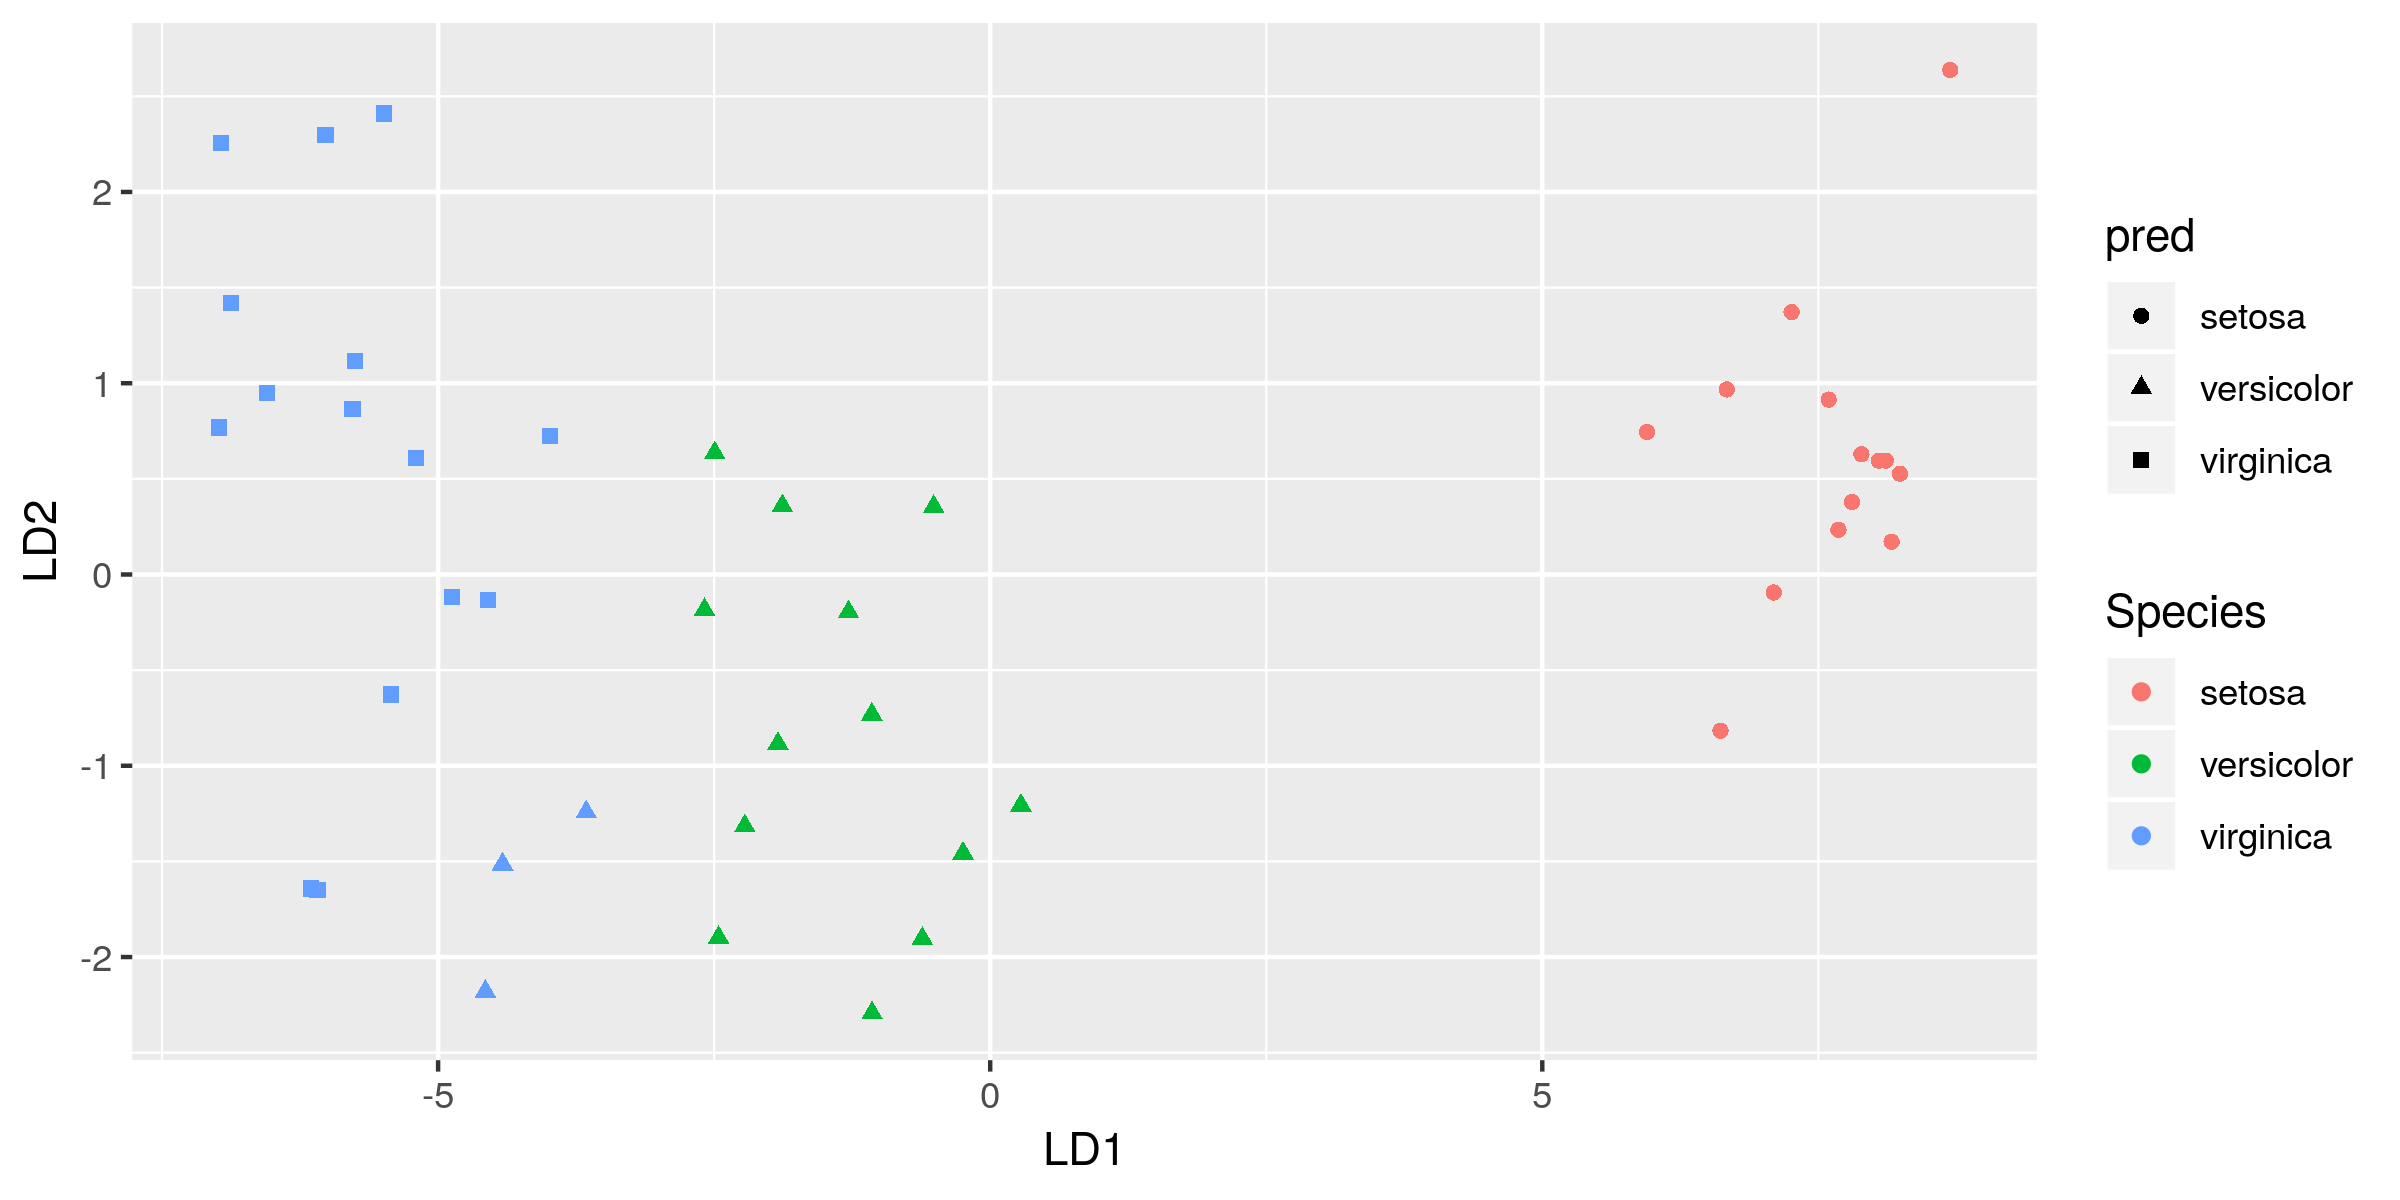

In [72]:
ggplot(iris_test_plot,aes(x=LD1,y=LD2,color=Species,shape=pred))+geom_point()

### Comparación con PCA

En PCA también podíamos reducir dimensionalidad, pero al ser agnóstico a la clasificación, no lo hace tan bien cuando tratamos de diferenciar clases etiquetadas a priori:

In [73]:
prmydata<-prcomp(X)
prmydata

Standard deviations (1, .., p=4):
[1] 2.0644326 0.4481292 0.2851751 0.1437300

Rotation (n x k) = (4 x 4):
                     PC1        PC2         PC3        PC4
Sepal.Length -0.36202591 -0.6892008 -0.56073146  0.2819925
Sepal.Width   0.08181696 -0.6941724  0.63389612 -0.3310685
Petal.Length -0.85532216  0.1940536  0.07509487 -0.4744765
Petal.Width  -0.36147922  0.0739602  0.52736771  0.7653404

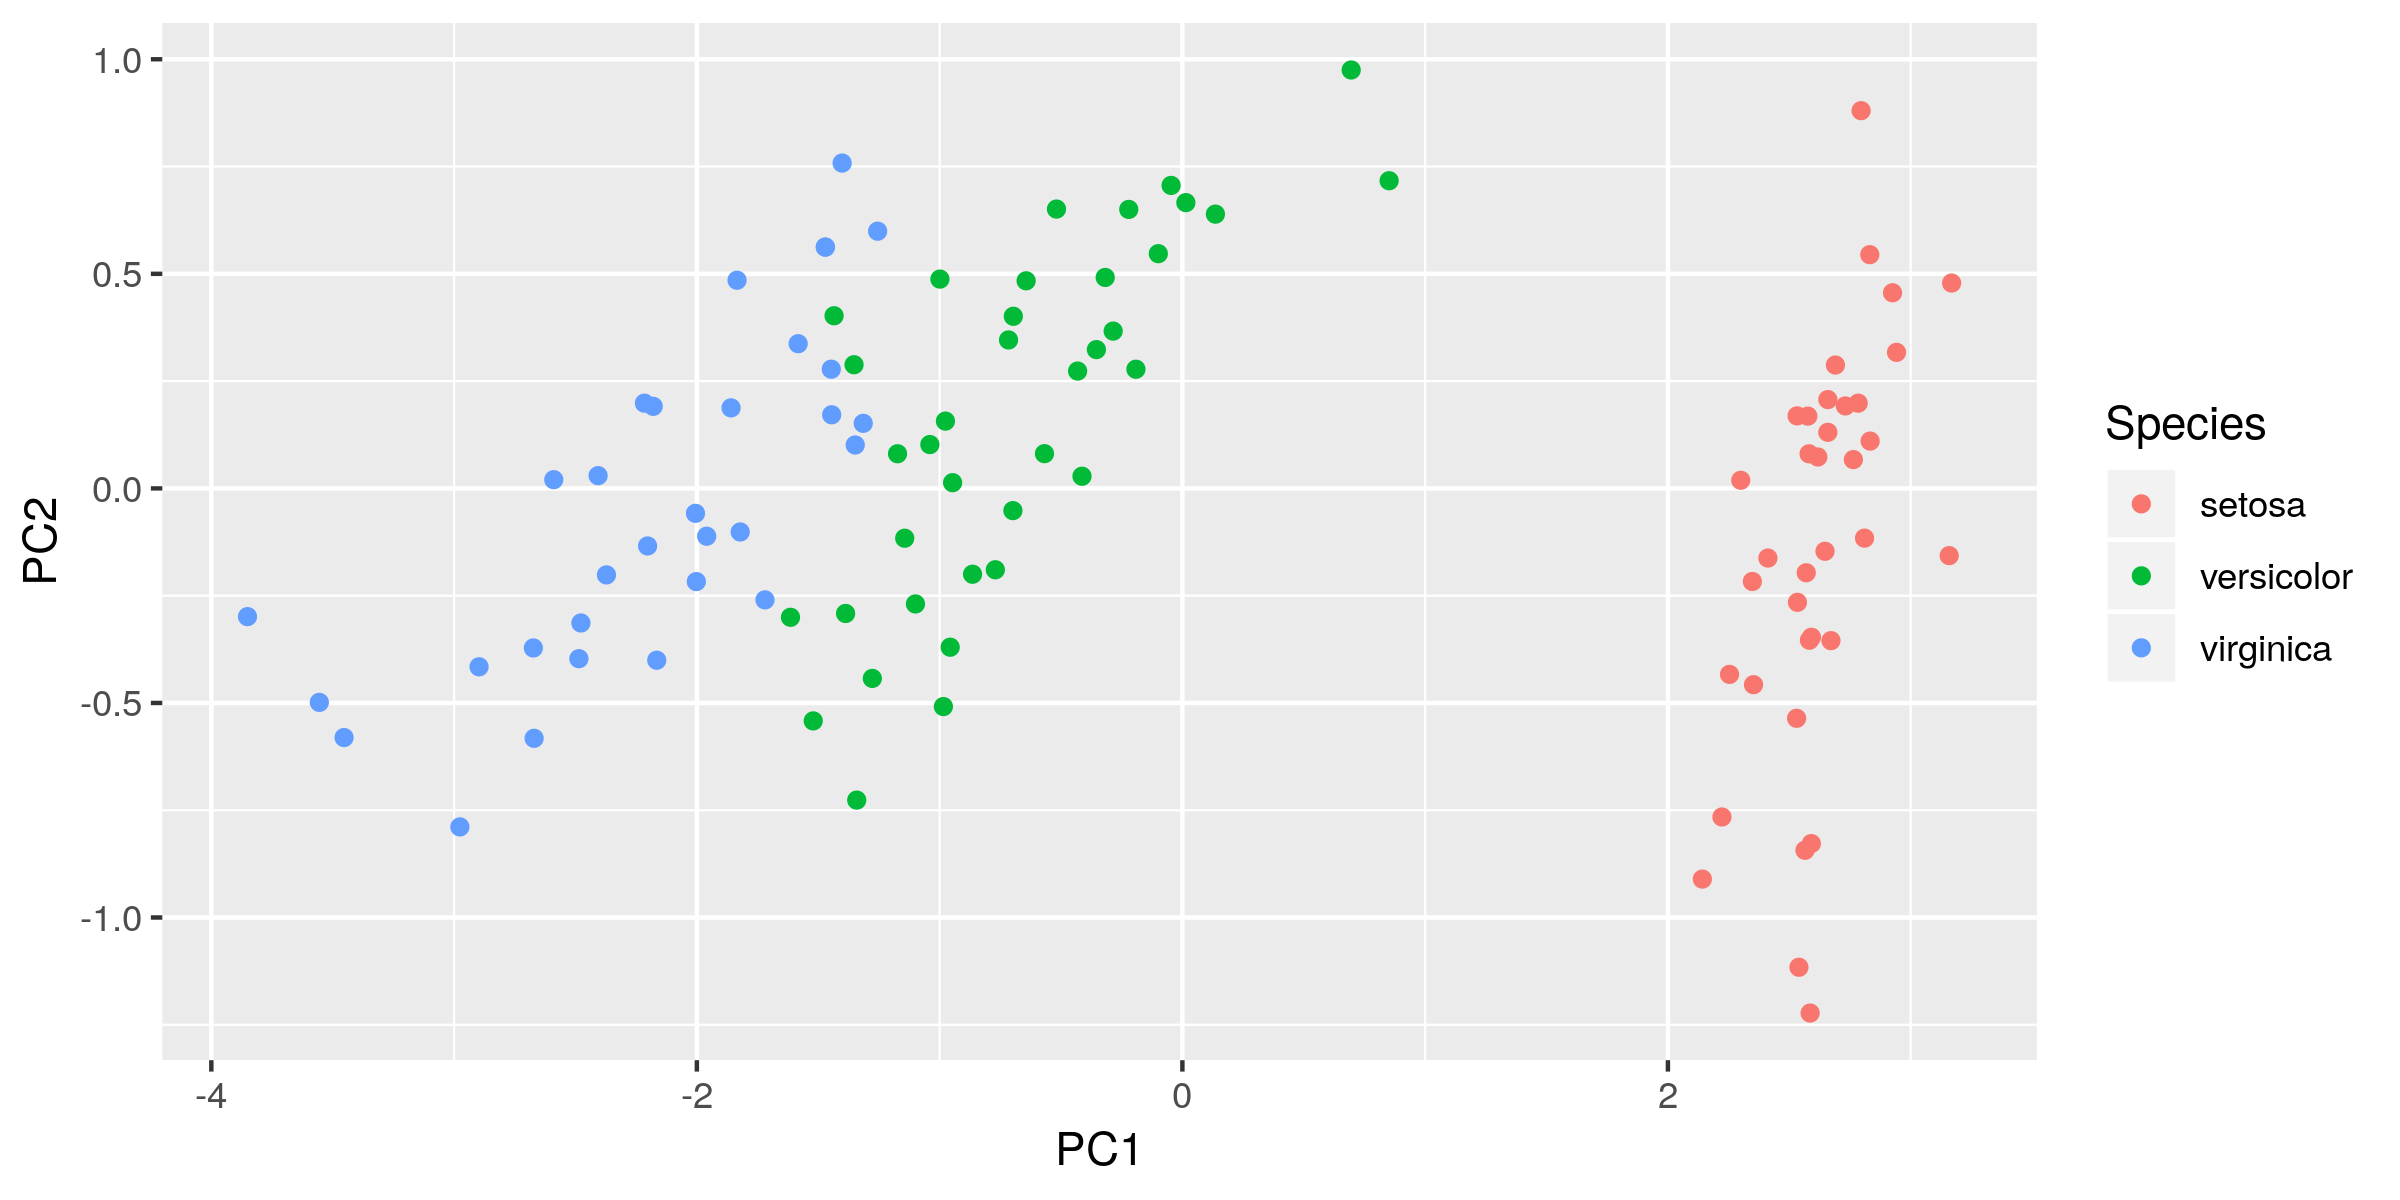

In [74]:
iris_train[,c("PC1","PC2")] <- predict(prmydata,newdata = iris_train[,1:4])[,1:2]

ggplot(iris_train,aes(x=PC1,y=PC2,color=Species))+geom_point()

Información de como repetir este mismo ejercicio en Python:
https://sebastianraschka.com/Articles/2014_python_lda.html#step-5-transforming-the-samples-onto-the-new-subspace